In [3]:
# Matplotlib settings

import warnings
import matplotlib.pyplot as plt
import shap
#sns.set_style("whitegrid")

plt.rcParams.update({
    'text.usetex': True,          # Enable LaTeX rendering
    'font.family': 'serif',       # Use serif fonts for a classic look
    'font.serif': ['Georgia'],    # Specify a serif font (e.g., Georgia)
    'font.weight': 'bold',      # Specify font weight                           ----------
    'figure.dpi': 200,            # Set the default DPI for clear visuals
    'figure.facecolor': 'white',  # Set the figure background color
    "axes.edgecolor": "grey",     # Border color for axes
    "axes.linewidth": 0.2,        # Border width for axes
    'axes.grid': True,            # Enable grid on axes
    'axes.labelweight': 'bold',       # Axis label bold                         ----------
    'axes.titleweight': 'bold',     # Axis title bold                           ----------
    'grid.color': 'grey',         # Grid color
    'grid.linestyle': '--',       # Dashed grid line style
    'grid.linewidth': 0.3,       # Grid line width
    'grid.alpha': 0.5,            # Grid transparency
    "axes.spines.top": False,     # Remove top spine
    "axes.spines.right": False,   # Remove right spine
    "legend.frameon": True,       # Enable frame around legends
    "legend.framealpha": 0.5      # Legend frame transparency
})

warnings.filterwarnings('ignore')

legend_box = dict(boxstyle="round,pad=0.3", fc="white", ec="0.8", alpha=0.9)

In [ ]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import xgboost as xgb

from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform

from SHAP_utils.shap_store import load_shap

In [ ]:
# Functions

#PFI
def process_importance(importance_result, feature_names, top_n=30):
    # Create Summary DF
    df = pd.DataFrame({
        "feature": feature_names,
        "importance_mean": importance_result.importances_mean
    }).sort_values("importance_mean", ascending=False).head(top_n)
    
    # Get the sorted list of features
    sorted_feats = df["feature"].tolist()
    
    # Create Tidy DF for Box Plots (only for the top N features)
    tidy_df = pd.DataFrame(importance_result.importances.T, columns=feature_names)
    tidy_df = tidy_df[sorted_feats].melt(var_name='feature', value_name='importance')
    
    return df, tidy_df, sorted_feats

def print_shap_importance(shap_values, feature_names, model_name):
    mean_abs = np.abs(shap_values.values).mean(axis=0)

    df = (
        pd.DataFrame({
            "feature": feature_names,
            "mean_abs_shap": mean_abs
        })
        .sort_values("mean_abs_shap", ascending=False)
        .reset_index(drop=True)
    )

    print(f"\n{model_name} — SHAP Feature Importance (mean |SHAP|)")
    print(df)
    
# Iterative Feature Addition Trajectory
def get_trajectory_data(ranking, mode, X_tr, y_tr, X_te, y_te):
    """
    Returns a DataFrame with:
    Step | Feature_Added | ROC_AUC
    """
    results = []

    if mode == "add_best":
        ordered = ranking
    elif mode == "add_worst":
        ordered = ranking[::-1]
    else:
        raise ValueError("Unsupported mode")

    for k in range(1, len(ordered) + 1):
        selected = ordered[:k]
        added_feature = ordered[k - 1]

        clf = LogisticRegression(max_iter=1000, random_state=42)
        clf.fit(X_tr[selected], y_tr)
        preds = clf.predict_proba(X_te[selected])[:, 1]
        score = roc_auc_score(y_te, preds)

        results.append({
            "Step": k,
            "Feature_Added": added_feature,
            "ROC_AUC": score
        })

    return pd.DataFrame(results)

def trajectory_to_xy(df):
    return df["Step"].values, df["ROC_AUC"].values

# Plot PFI
def plot_pfi(pfi_result, feature_names, title):
    plt.figure(figsize=(10, 6))
    indices = pfi_result.importances_mean.argsort()[::-1]
    
    plt.barh(range(len(indices)), pfi_result.importances_mean[indices], color='#ff0d57', edgecolor='k')
    plt.yticks(range(len(indices)), np.array(feature_names)[indices], fontsize=14)
    plt.gca().invert_yaxis()
    #plt.title(title, fontsize=16)
    plt.xlabel("Mean Decrease in ROC AUC Score", fontsize=16)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.xticks(fontsize=14)
    plt.tight_layout()
    plt.show()
    
    
def print_pfi_table(importance_result, feature_names, model_name):
    df = pd.DataFrame({
        "feature": feature_names,
        "mean_roc_auc_decrease": importance_result.importances_mean
    }).sort_values("mean_roc_auc_decrease", ascending=False)
    
    print(f"\n{model_name} — Permutation Feature Importance (ROC-AUC)")
    print(df.to_string(index=False))
    
#NMI
def freedman_diaconis_bins(x):
    x = np.asarray(x).astype(float)
    x = x[~np.isnan(x)]
    if len(x) == 0: 
        return 1
    
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    n = len(x)

    if iqr == 0: 
        return int(np.sqrt(n))

    bin_width = 2 * iqr / (n ** (1/3))
    if bin_width == 0:
        return int(np.sqrt(n))
        
    bins = int(np.ceil((x.max() - x.min()) / bin_width))
    return max(2, bins)

def shannon_entropy(x, bins):
    x = x[~np.isnan(x)]
    hist, _ = np.histogram(x, bins=bins, density=False)
    prob = hist / hist.sum()
    prob = prob[prob > 0]
    return entropy(prob, base=2)

def mutual_information(x, y, bins_x, bins_y):
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    
    joint_hist, _, _ = np.histogram2d(x, y, bins=[bins_x, bins_y])
    joint_prob = joint_hist / joint_hist.sum()

    px = joint_prob.sum(axis=1)
    py = joint_prob.sum(axis=0)

    mi = 0.0
    for i in range(joint_prob.shape[0]):
        for j in range(joint_prob.shape[1]):
            if joint_prob[i, j] > 0:
                mi += joint_prob[i, j] * np.log2(
                    joint_prob[i, j] / (px[i] * py[j])
                )
    return mi

def normalized_mutual_information(x, y):
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask].astype(float)
    y = y[mask].astype(float)

    bx = freedman_diaconis_bins(x)
    by = freedman_diaconis_bins(y)

    hx = shannon_entropy(x, bx)
    hy = shannon_entropy(y, by)
    mi = mutual_information(x, y, bx, by)
    
    denominator = np.sqrt(hx * hy)
    if denominator == 0: 
        return 0.0
    return mi / denominator

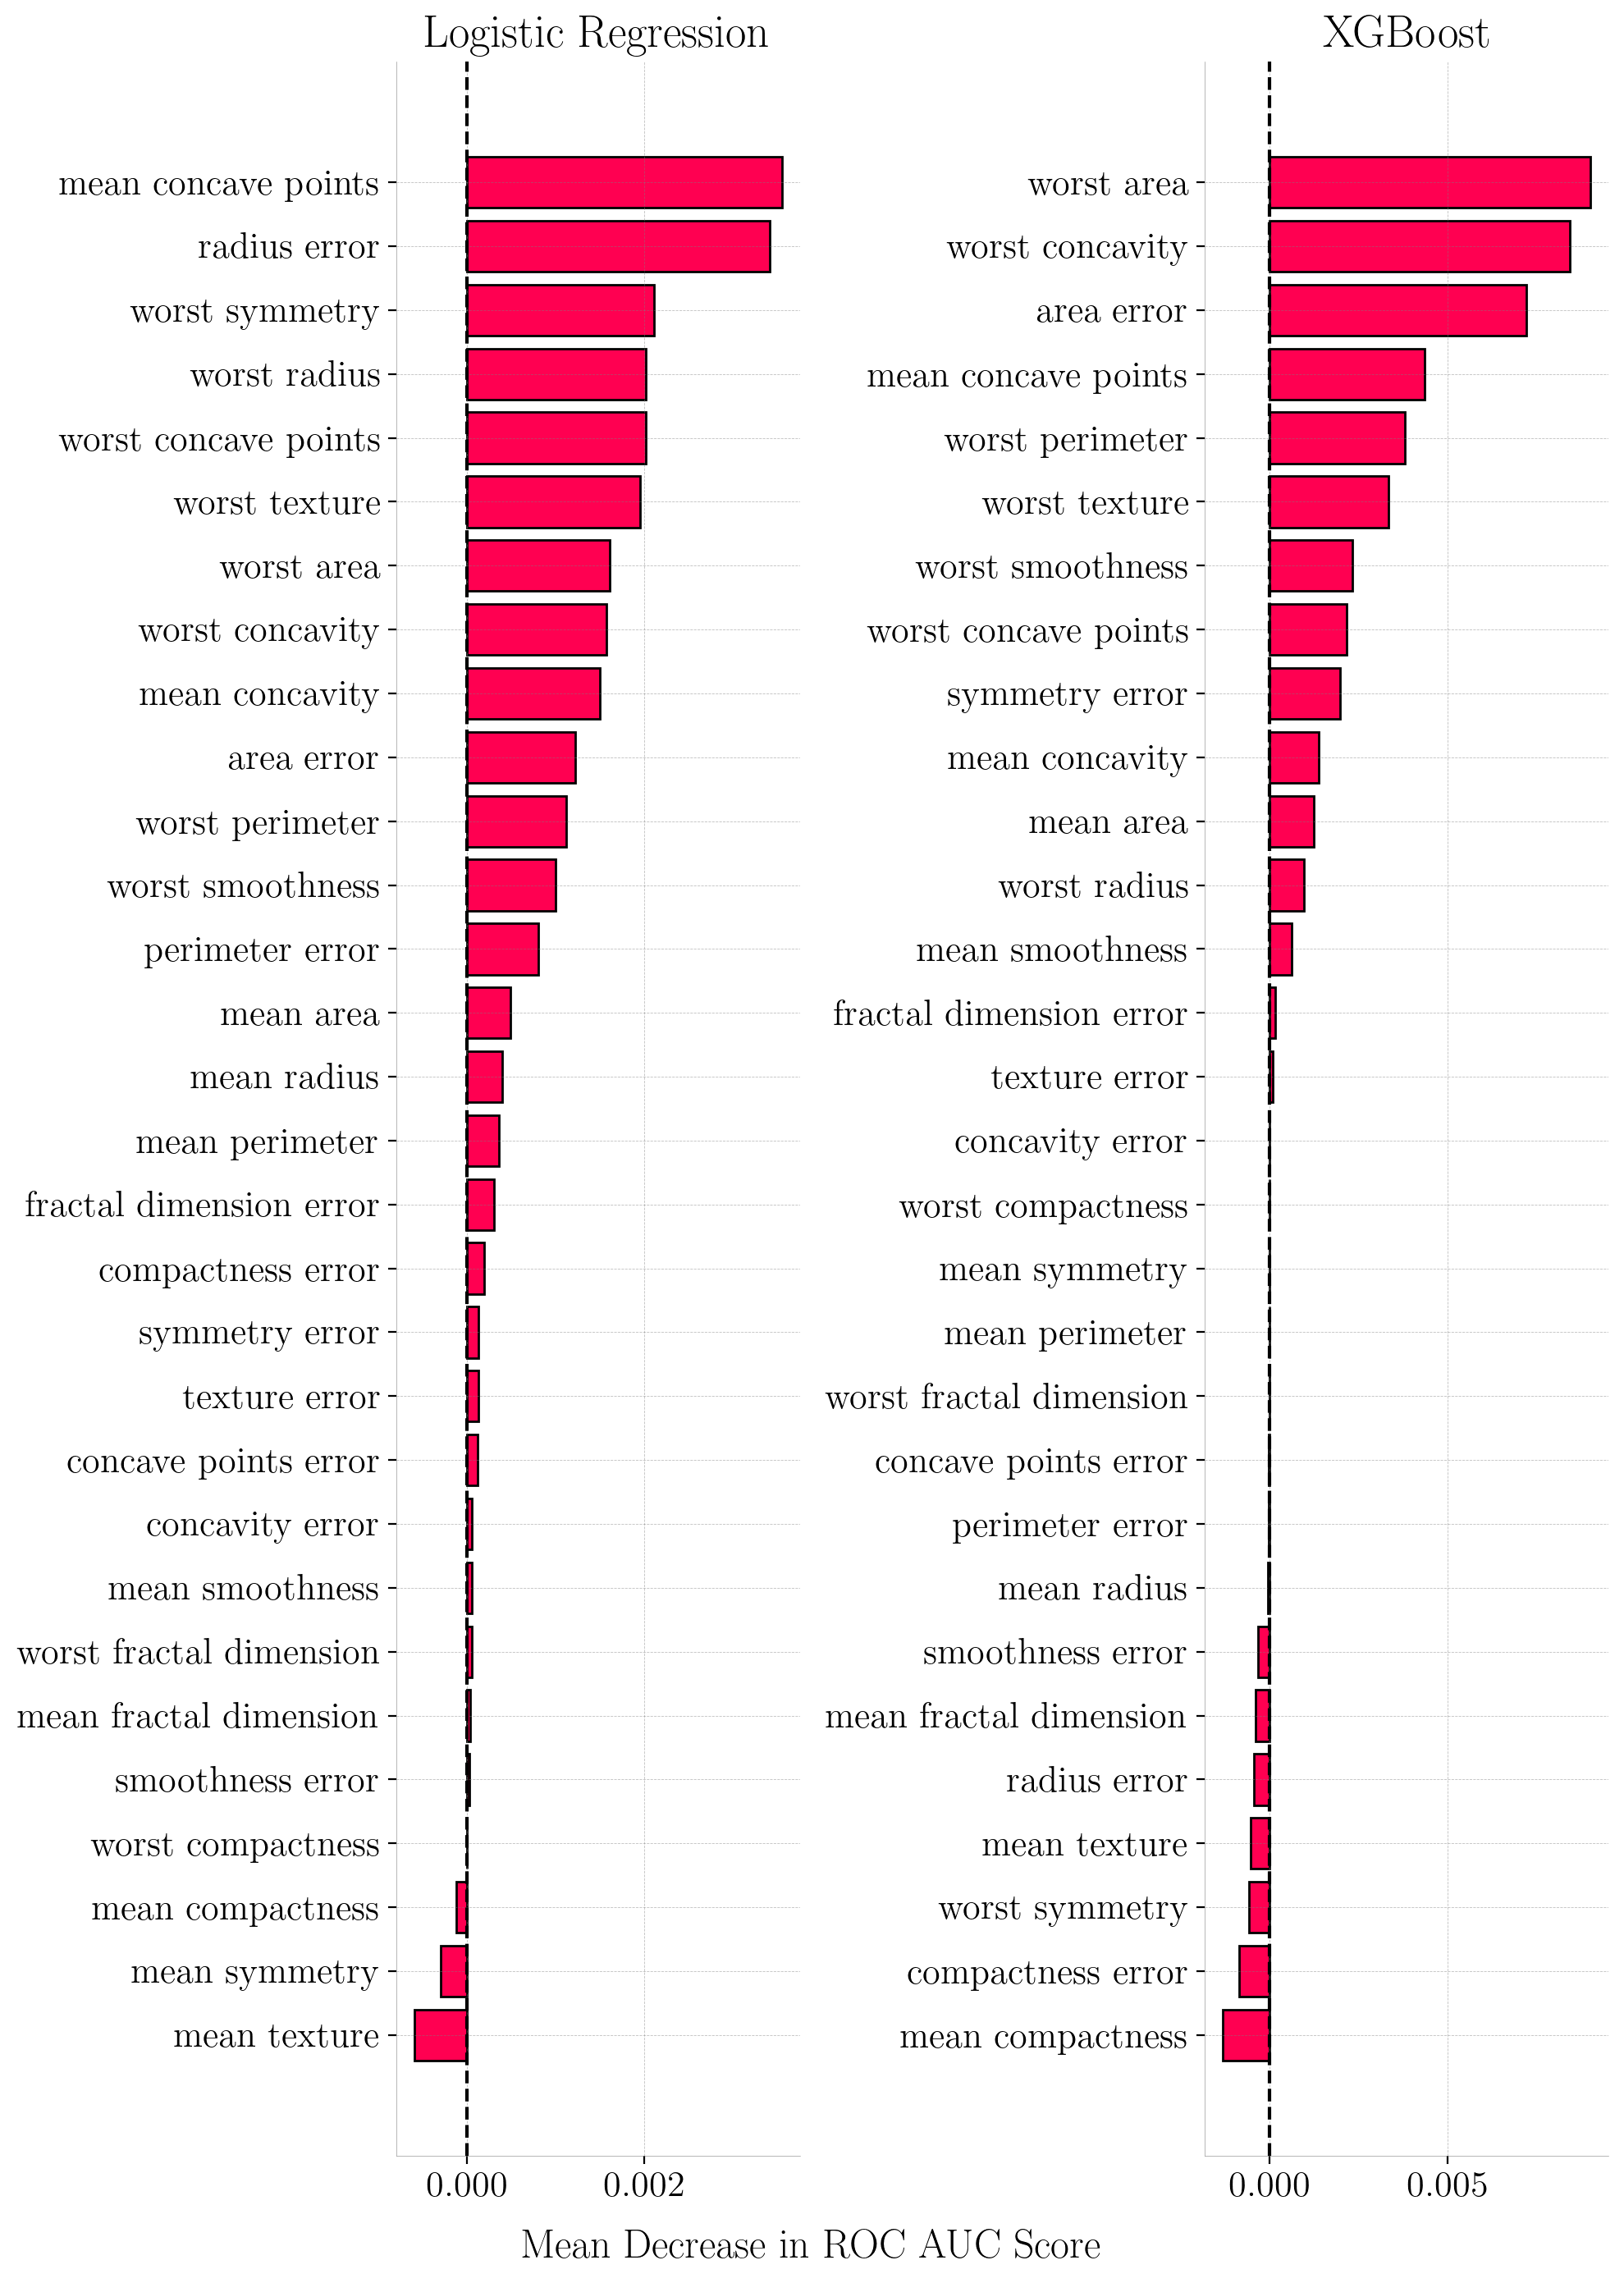

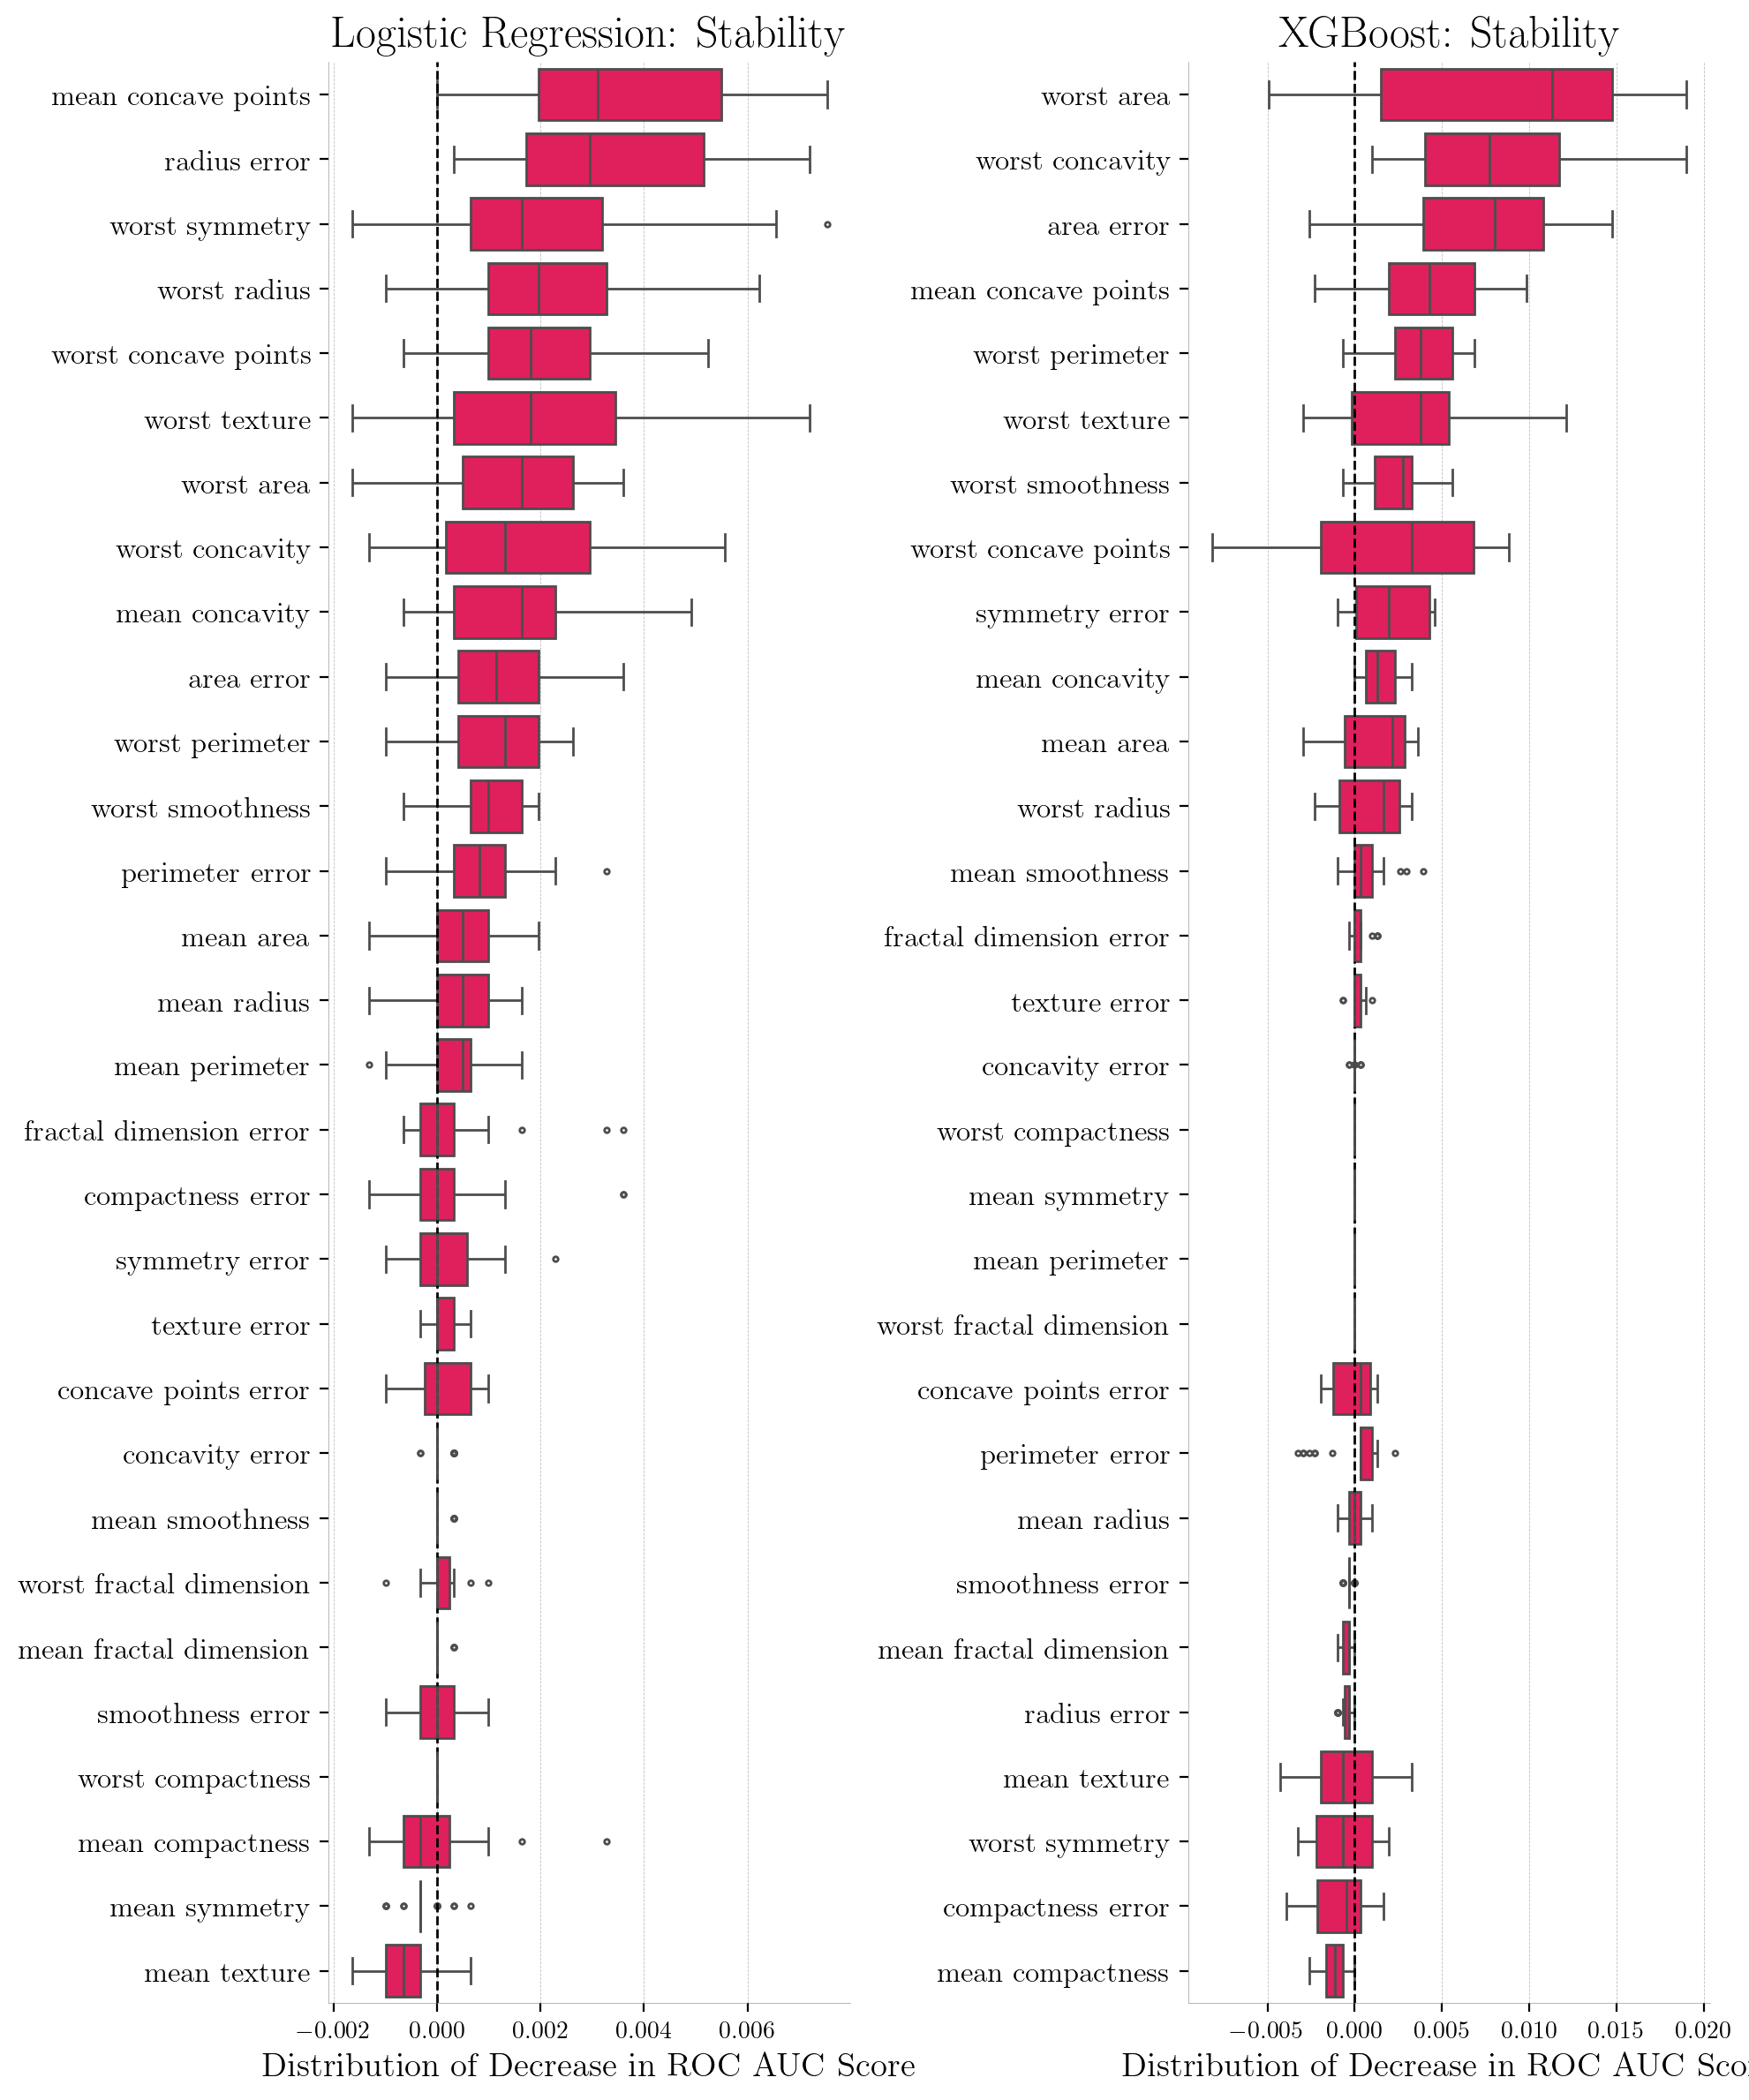

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Logistic Regression ROC AUC Score:
0.99737962659679
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        43
           1       0.96      0.97      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

XGBoost ROC AUC Score:
0.9908286930887652

Logistic Regression — Permutation Feature Importance (ROC-AUC)
                feature  mean_roc_auc_decrease
    mean concave points               0.003548
           radius er

In [ ]:
#PFI
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_lr.fit(X_train_scaled, y_train)

model_xgb = xgb.XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
model_xgb.fit(X_train, y_train)

r_lr = permutation_importance(model_lr, X_test_scaled, y_test, n_repeats=30, random_state=42, scoring='roc_auc')
r_xgb = permutation_importance(model_xgb, X_test, y_test, n_repeats=30, random_state=42, scoring='roc_auc')

df_lr, tidy_lr, feats_lr = process_importance(r_lr, X.columns)
df_xgb, tidy_xgb, feats_xgb = process_importance(r_xgb, X.columns)

shap_red = mcolors.to_hex(shap.plots.colors.red_blue(1.0))

fig1, axes1 = plt.subplots(nrows=1, ncols=2, figsize=(10, 14))

axes1[0].barh(df_lr["feature"], df_lr["importance_mean"], color=shap_red, edgecolor="black")
axes1[0].invert_yaxis()
axes1[0].set_title("Logistic Regression", fontsize=20)
#axes1[0].set_xlabel("Mean Decrease in ROC AUC Score", fontsize=16)
axes1[0].axvline(0, color='k', linestyle='--')
axes1[0].tick_params(axis='y', labelsize=16)
axes1[0].tick_params(axis='x', labelsize=16)

axes1[1].barh(df_xgb["feature"], df_xgb["importance_mean"], color=shap_red, edgecolor="black")
axes1[1].invert_yaxis()
axes1[1].set_title("XGBoost", fontsize=20)
#axes1[1].set_xlabel("Mean Decrease in ROC AUC Score", fontsize=16)
axes1[1].axvline(0, color='k', linestyle='--')
axes1[1].tick_params(axis='y', labelsize=16)
axes1[1].tick_params(axis='x', labelsize=16)
fig1.supxlabel("Mean Decrease in ROC AUC Score", fontsize=18)
plt.tight_layout()
plt.show()

fig2, axes2 = plt.subplots(nrows=1, ncols=2, figsize=(10, 12))

sns.boxplot(
    data=tidy_lr, x='importance', y='feature', order=feats_lr,
    orient='h', ax=axes2[0], color=shap_red, fliersize=2
)
axes2[0].set_title("Logistic Regression: Stability", fontsize=18)
axes2[0].set_xlabel("Distribution of Decrease in ROC AUC Score", fontsize=14)
axes2[0].set_ylabel("")
axes2[0].axvline(0, color='k', linestyle='--', linewidth=1)
axes2[0].tick_params(axis='y', labelsize=12)

sns.boxplot(
    data=tidy_xgb, x='importance', y='feature', order=feats_xgb,
    orient='h', ax=axes2[1], color=shap_red, fliersize=2
)
axes2[1].set_title("XGBoost: Stability", fontsize=18)
axes2[1].set_xlabel("Distribution of Decrease in ROC AUC Score", fontsize=14)
axes2[1].set_ylabel("")
axes2[1].axvline(0, color='k', linestyle='--', linewidth=1)
axes2[1].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

print("Logistic Regression Classification Report:")
y_pred_lr = model_lr.predict(X_test_scaled)
print(classification_report(y_test, y_pred_lr))
print("Logistic Regression ROC AUC Score:")
print(roc_auc_score(y_test, model_lr.predict_proba(X_test_scaled)[:, 1]))

print("XGBoost Classification Report:")
y_pred_xgb = model_xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb))
print("XGBoost ROC AUC Score:")
print(roc_auc_score(y_test, model_xgb.predict_proba(X_test)[:, 1]))

print_pfi_table(r_lr, X.columns, "Logistic Regression")
print_pfi_table(r_xgb, X.columns, "XGBoost")


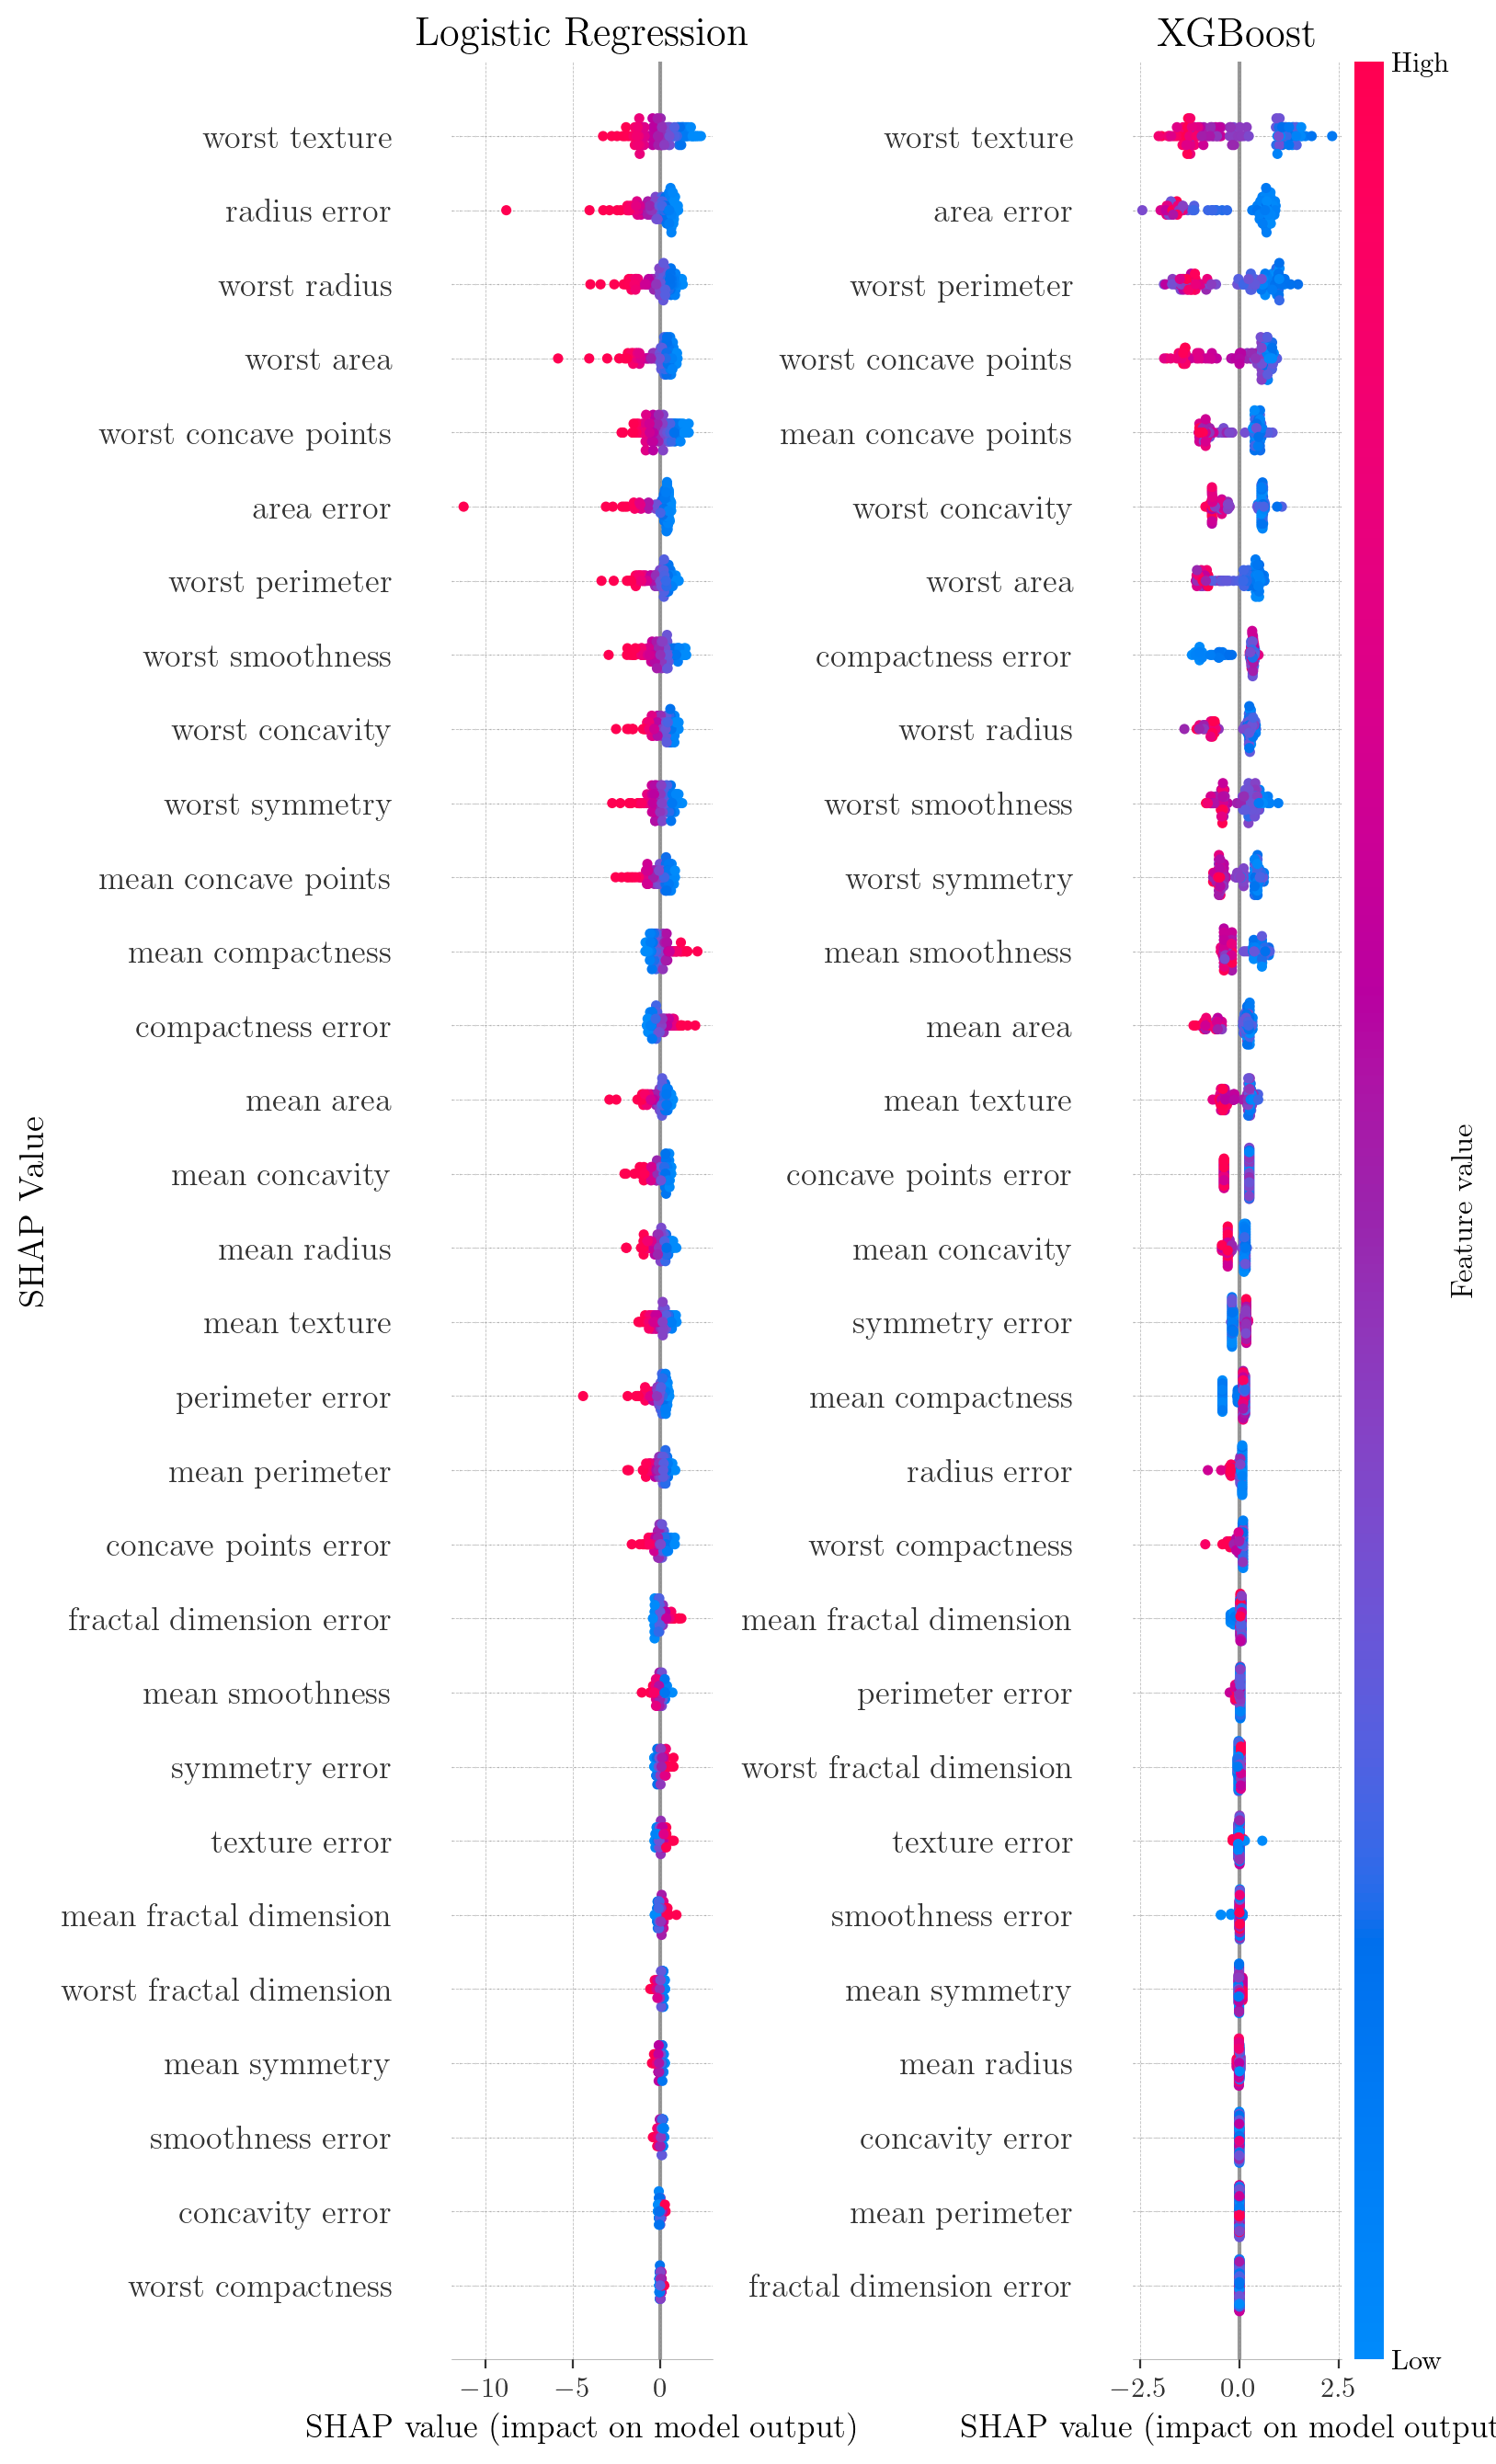


Logistic Regression — SHAP Feature Importance (mean |SHAP|)
                    feature  mean_abs_shap
0             worst texture       0.961677
1              radius error       0.797260
2              worst radius       0.761366
3                worst area       0.745310
4      worst concave points       0.722015
5                area error       0.639141
6           worst perimeter       0.610906
7          worst smoothness       0.603310
8           worst concavity       0.546258
9            worst symmetry       0.535822
10      mean concave points       0.535767
11         mean compactness       0.477367
12        compactness error       0.430954
13                mean area       0.417388
14           mean concavity       0.399106
15              mean radius       0.398947
16             mean texture       0.395467
17          perimeter error       0.372442
18           mean perimeter       0.370332
19     concave points error       0.299025
20  fractal dimension error       0.

In [ ]:
# SHAP Summary Plot on Full Dataset

shap_lr_data = load_shap("shap_results/breast_cancer_logreg.pkl")
shap_xgb_data = load_shap("shap_results/breast_cancer_xgboost.pkl")

shap_values_lr = shap_lr_data["shap_values"]
shap_values_xgb = shap_xgb_data["shap_values"]

feature_names = shap_lr_data["feature_names"]

shap_lr = shap.Explanation(
    values=shap_values_lr,
    base_values=shap_lr_data["base_values"],
    data=shap_lr_data["data"],
    feature_names=feature_names
)

shap_xgb = shap.Explanation(
    values=shap_values_xgb,
    base_values=shap_xgb_data["base_values"],
    data=shap_xgb_data["data"],
    feature_names=feature_names
)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 12))

plt.sca(axes[0])
plt.title("Logistic Regression", fontsize=16)
plt.ylabel("SHAP Value", fontsize=14)
shap.plots.beeswarm(shap_lr, show=False, color_bar=False, max_display=30)

plt.sca(axes[1])
plt.title("XGBoost", fontsize=16)
shap.plots.beeswarm(shap_xgb, show=False, color_bar=True, max_display=30)

plt.tight_layout()
plt.show()

print_shap_importance(shap_lr, feature_names, "Logistic Regression")
print_shap_importance(shap_xgb, feature_names, "XGBoost")

print("\n" + "="*50)
print("LOGISTIC REGRESSION: COEFFICIENTS (Sorted by Magnitude)")
print("="*50)
if "coefficients" in shap_lr_data.get("extra_meta", {}):
    df_coeffs = shap_lr_data["extra_meta"]["coefficients"]
    print(df_coeffs[['Feature', 'Coefficient']].to_string(index=False))
else:
    print("Coefficients not found. Please re-run the training script.")

print("\n" + "="*50)
print("XGBOOST: GAIN (Sorted Descending)")
print("="*50)
if "gain" in shap_xgb_data.get("extra_meta", {}):
    df_gain = shap_xgb_data["extra_meta"]["gain"]
    print(df_gain.to_string(index=False))
else:
    print("Gain data not found. Please re-run the training script.")


Loading and preprocessing Breast Cancer dataset...
Training baseline Logistic Regression model...
Baseline ROC AUC: 0.9974

Calculating feature rankings...
Generating Iterative Feature Selection Scores...

######################################################################
SCENARIO: ADD BEST
######################################################################

--- Method: SHAP ---
 Step           Feature_Added  ROC_AUC
    1           worst texture 0.752211
    2            radius error 0.932853
    3            worst radius 0.989846
    4              worst area 0.990501
    5    worst concave points 0.997707
    6              area error 0.997380
    7         worst perimeter 0.998035
    8        worst smoothness 0.998690
    9         worst concavity 0.998690
   10          worst symmetry 0.998362
   11     mean concave points 0.998035
   12        mean compactness 0.997707
   13       compactness error 0.998035
   14               mean area 0.998035
   15          mean concav

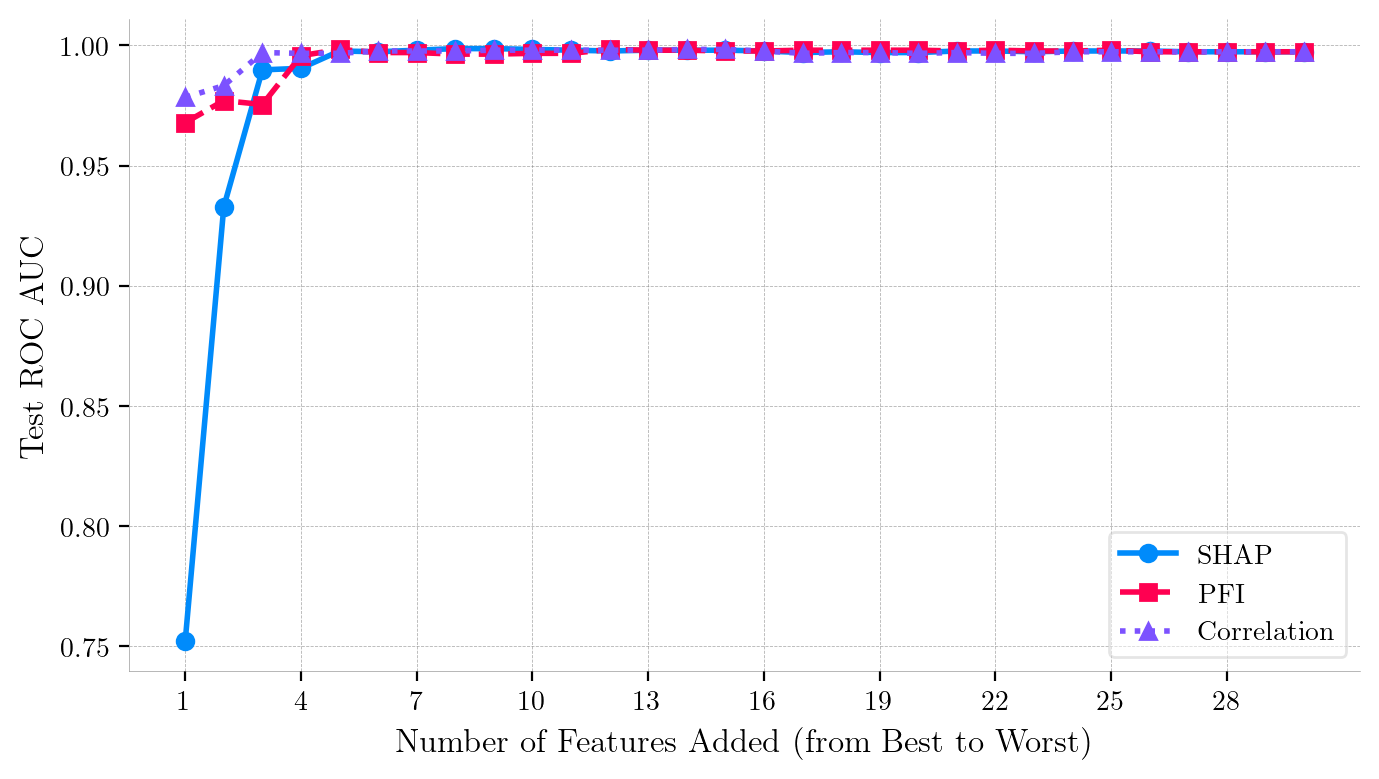

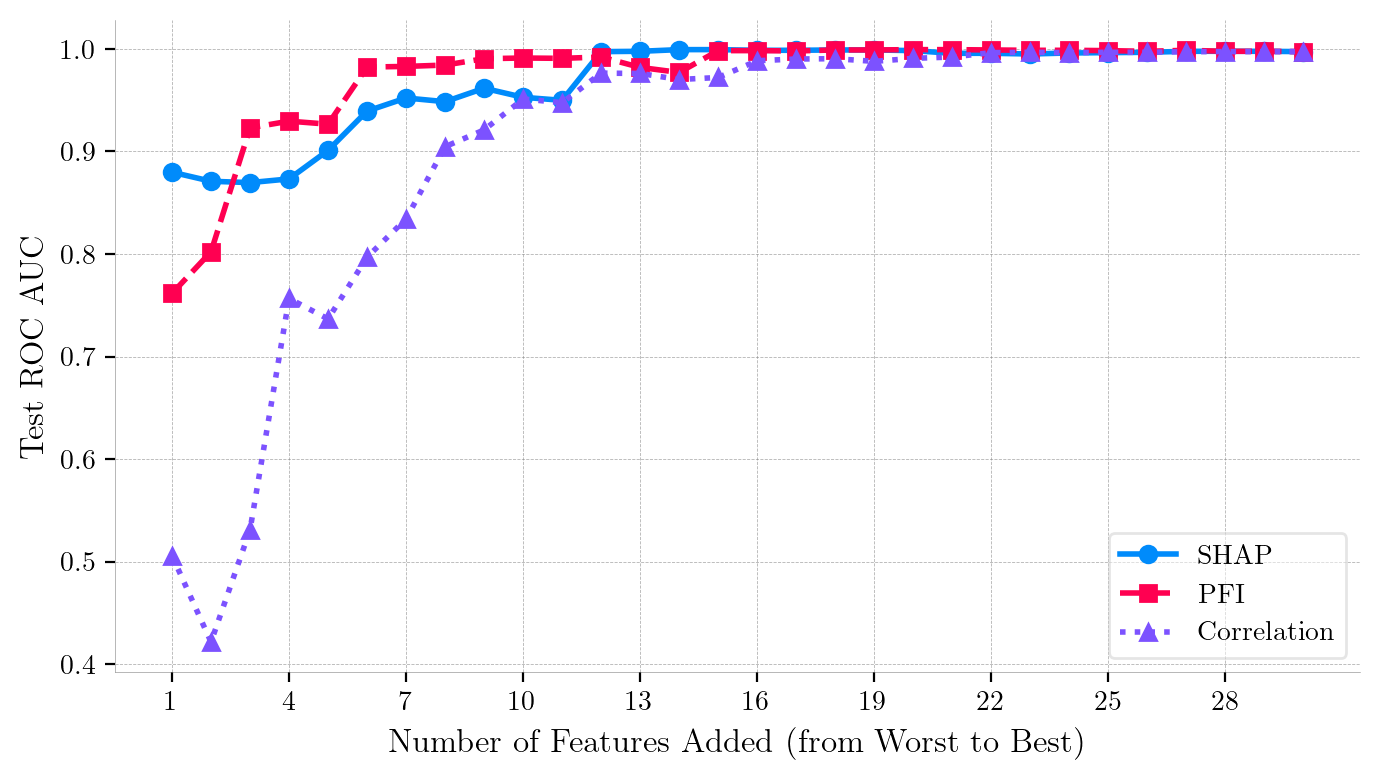

Done.


In [ ]:
# Iterative Feature Addition on Full Dataset

print("Loading and preprocessing Breast Cancer dataset...")

data = load_breast_cancer(as_frame=True)
X = data.data
y = data.target
feature_names = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=feature_names,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=feature_names,
    index=X_test.index
)

print("Training baseline Logistic Regression model...")
baseline_model = LogisticRegression(max_iter=1000, random_state=42)
baseline_model.fit(X_train_scaled, y_train)

baseline_pred = baseline_model.predict_proba(X_test_scaled)[:, 1]
print(f"Baseline ROC AUC: {roc_auc_score(y_test, baseline_pred):.4f}")
print("=" * 60, "\n")
print("Calculating feature rankings...")

shap_ranking = [
    "worst texture",
    "radius error",
    "worst radius",
    "worst area",
    "worst concave points",
    "area error",
    "worst perimeter",
    "worst smoothness",
    "worst concavity",
    "worst symmetry",
    "mean concave points",
    "mean compactness",
    "compactness error",
    "mean area",
    "mean concavity",
    "mean radius",
    "mean texture",
    "perimeter error",
    "mean perimeter",
    "concave points error",
    "fractal dimension error",
    "mean smoothness",
    "symmetry error",
    "texture error",
    "mean fractal dimension",
    "worst fractal dimension",
    "mean symmetry",
    "smoothness error",
    "concavity error",
    "worst compactness"
]

pfi = permutation_importance(
    baseline_model,
    X_test_scaled,
    y_test,
    n_repeats=30,
    random_state=42,
    scoring="roc_auc",
    n_jobs=-1
)
pfi_ranking = [
    f for _, f in sorted(zip(pfi.importances_mean, feature_names), reverse=True)
]

train_df = X_train_scaled.copy()
train_df["target"] = y_train.values
corr_values = (
    train_df.corr()["target"]
    .abs()
    .drop("target")
    .sort_values(ascending=False)
)
corr_ranking = corr_values.index.tolist()

rankings = {
    "SHAP": shap_ranking,
    "PFI": pfi_ranking,
    "Correlation": corr_ranking
}

print("Generating Iterative Feature Selection Scores...\n")

scenarios = ["add_best", "add_worst"]

for mode in scenarios:
    print("#" * 70)
    print(f"SCENARIO: {mode.upper().replace('_', ' ')}")
    print("#" * 70)

    for method, ranking in rankings.items():
        print(f"\n--- Method: {method} ---")
        df = get_trajectory_data(
            ranking, mode,
            X_train_scaled, y_train,
            X_test_scaled, y_test
        )
        print(df.to_string(index=False))
        print("-" * 50)

print("Tables generated.")
print("=" * 60)

colors = {"SHAP": "#008BFB", "PFI": "#FF0051", "Correlation": "#7C52FF"}
markers = {"SHAP": "o", "PFI": "s", "Correlation": "^"}
styles = {"SHAP": "-", "PFI": "--", "Correlation": ":"}

plot_scenarios = [
    ("add_best", "Number of Features Added (from Best to Worst)"),
    ("add_worst", "Number of Features Added (from Worst to Best)")
]

print("Generating plots...")

for mode, xlabel in plot_scenarios:
    plt.figure(figsize=(7, 4))

    for method, ranking in rankings.items():
        df = get_trajectory_data(
            ranking, mode,
            X_train_scaled, y_train,
            X_test_scaled, y_test
        )
        xs, ys = trajectory_to_xy(df)

        plt.plot(
            xs, ys,
            label=method,
            color=colors[method],
            marker=markers[method],
            linestyle=styles[method],
            linewidth=2,
            markersize=6
        )
        
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel("Test ROC AUC", fontsize=12)
    #plt.title(f"Scenario: {mode.replace('_', ' ').title()}", fontsize=14)
    plt.xticks(range(1, len(feature_names) + 1, 3))
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

print("Done.")

In [1]:
# Summary Statistics
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np

data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target 

df = X.copy()
df['Target'] = y

print("1. Target Class Distribution:")
print(f"   - Class 0 (Malignant): {(y==0).mean():.2%}")
print(f"   - Class 1 (Benign):    {(y==1).mean():.2%}")
print("-" * 30)

malignant_texture = df[df['Target'] == 0]['worst texture'].mean()
benign_texture = df[df['Target'] == 1]['worst texture'].mean()
print("2. Worst Texture Analysis:")
print(f"   - Mean 'worst texture' for Malignant (0): {malignant_texture:.2f}")
print(f"   - Mean 'worst texture' for Benign (1):    {benign_texture:.2f}")
print(f"   - Conclusion: Higher texture correlates with Malignancy (0).")
print("-" * 30)

print("3. Correlation Analysis (Redundancy):")
corr_matrix = df[['worst compactness', 'worst area', 'worst perimeter', 'worst concave points']].corr()
print(corr_matrix)

1. Target Class Distribution:
   - Class 0 (Malignant): 37.26%
   - Class 1 (Benign):    62.74%
------------------------------
2. Worst Texture Analysis:
   - Mean 'worst texture' for Malignant (0): 29.32
   - Mean 'worst texture' for Benign (1):    23.52
   - Conclusion: Higher texture correlates with Malignancy (0).
------------------------------
3. Correlation Analysis (Redundancy):
                      worst compactness  worst area  worst perimeter  \
worst compactness              1.000000    0.438296         0.529408   
worst area                     0.438296    1.000000         0.977578   
worst perimeter                0.529408    0.977578         1.000000   
worst concave points           0.801080    0.747419         0.816322   

                      worst concave points  
worst compactness                 0.801080  
worst area                        0.747419  
worst perimeter                   0.816322  
worst concave points              1.000000  


Performing Hierarchical Clustering...


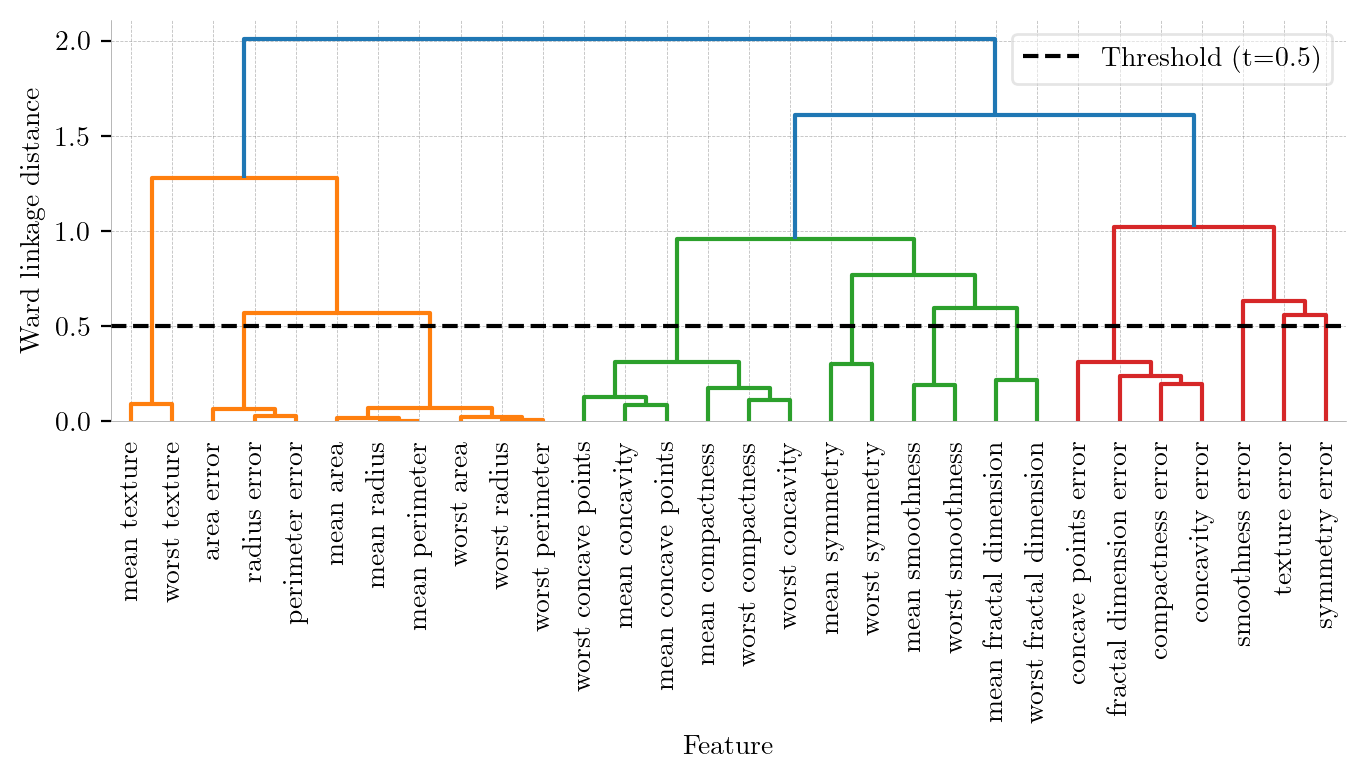

Reduced features from 30 to 11
Selected Representatives: ['worst texture', 'radius error', 'worst perimeter', 'worst concave points', 'worst symmetry', 'worst smoothness', 'worst fractal dimension', 'concave points error', 'texture error', 'symmetry error', 'smoothness error']

AFTER - Reduced Model Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

AFTER - Reduced Model ROC AUC Score: 0.9967

SHAP Feature Importance (Reduced Model):
                Feature  Mean_Abs_SHAP
        worst perimeter       2.228430
           radius error       1.549567
   worst concave points       1.545244
          worst texture       1.386844
         worst symmetry       0.767162
         symmetry error      

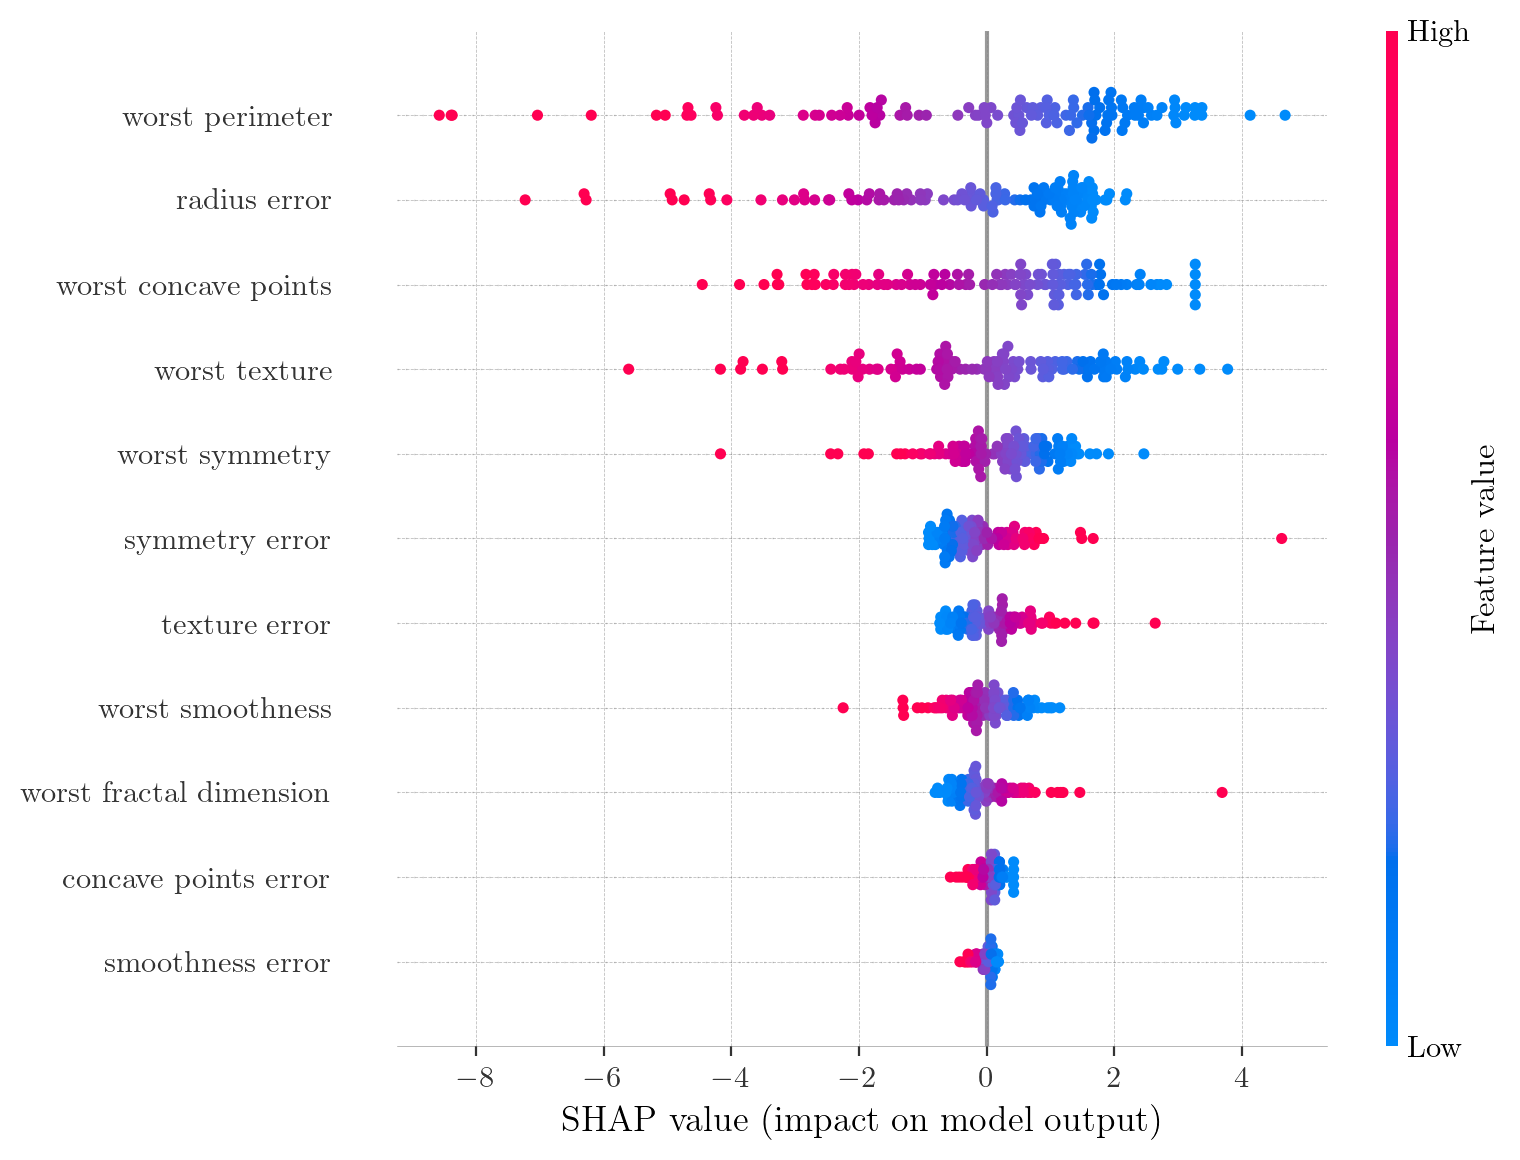

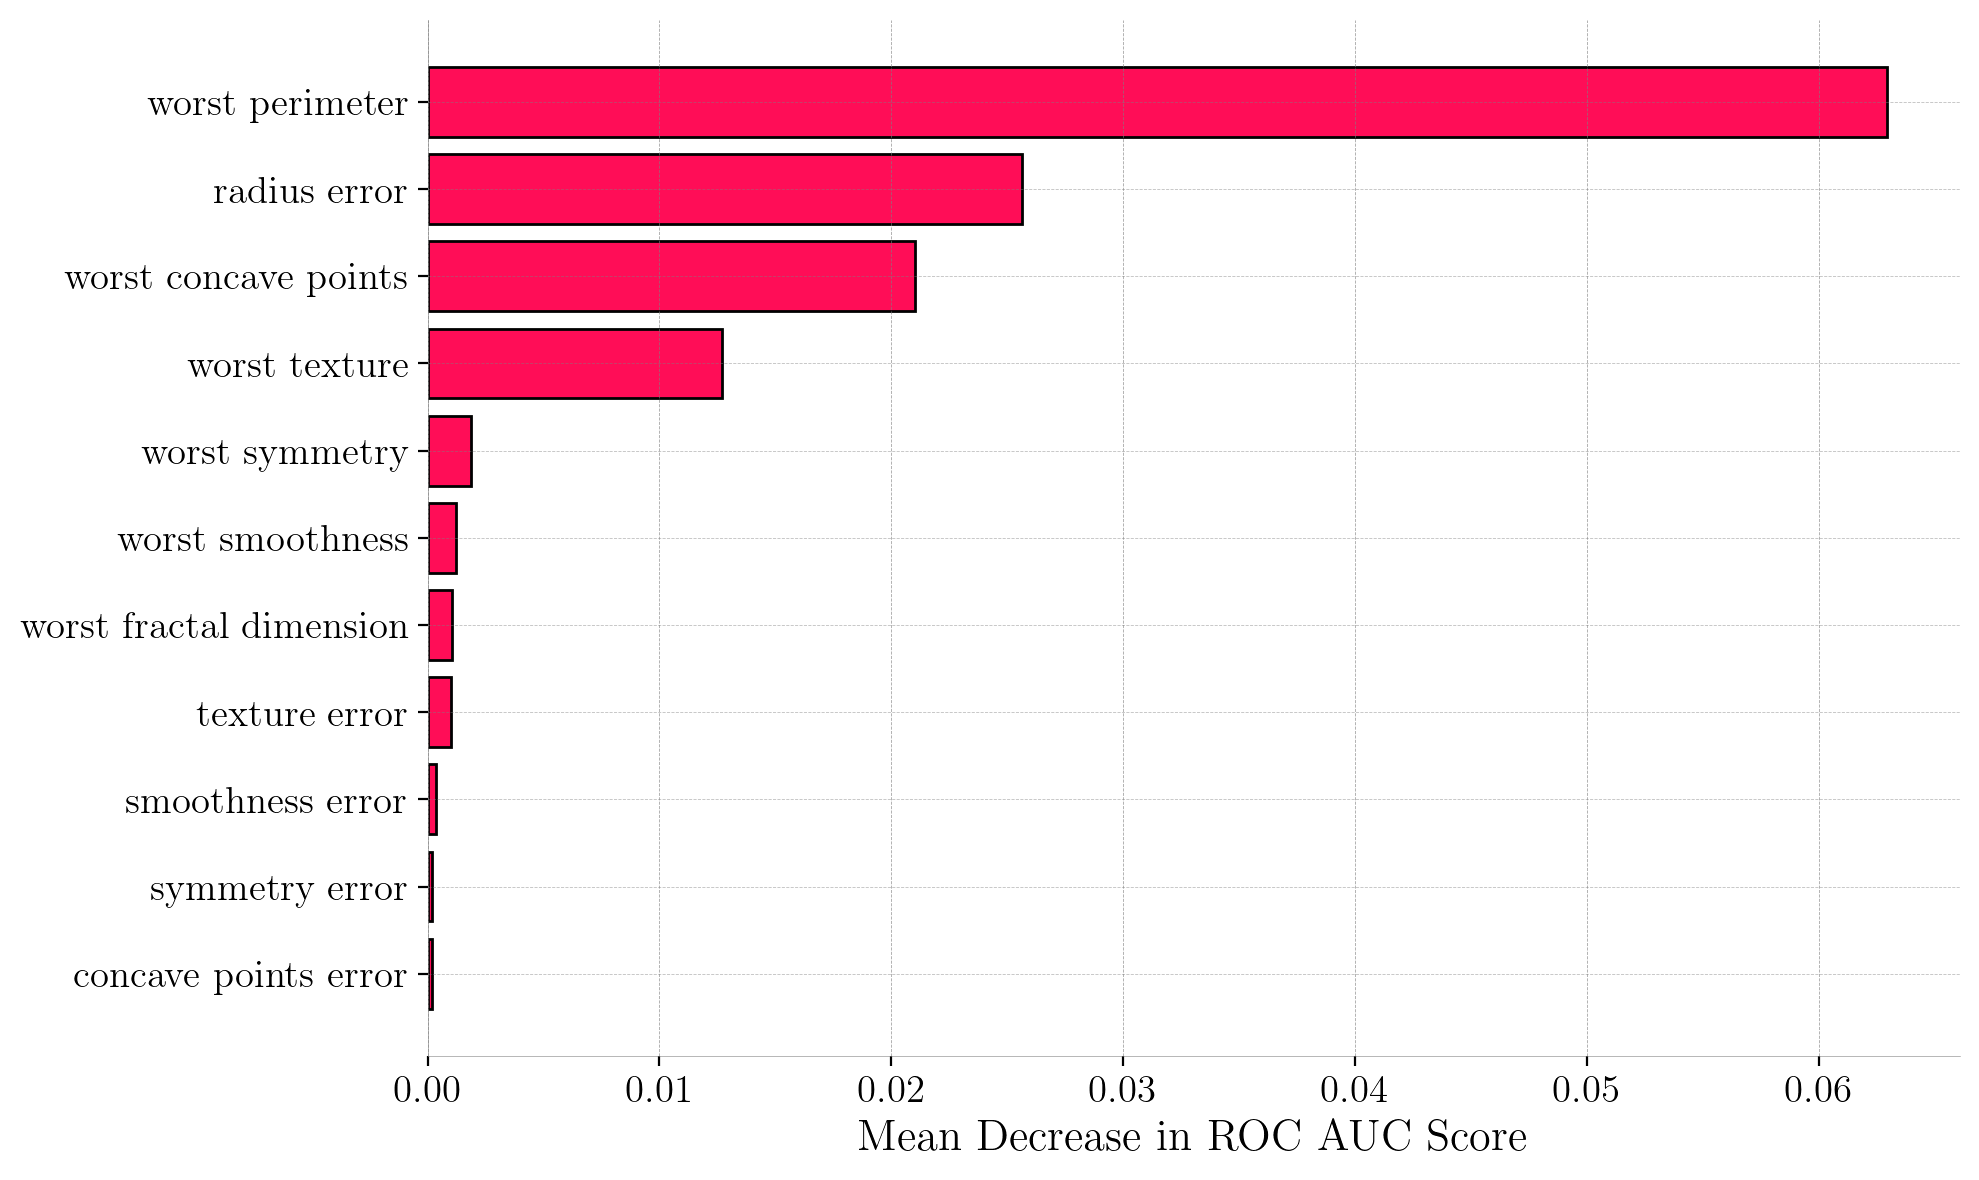

In [ ]:
# Handling multicollinearity (Clustering + SHAP & PFI After)
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

print("Performing Hierarchical Clustering...")

corr = X_train_scaled.corr(method='pearson')

distance_matrix = 1 - np.abs(corr)
linkage_matrix = sch.linkage(squareform(distance_matrix), method='ward')

plt.figure(figsize=(7, 4))
#plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)', fontsize=16)
plt.xlabel('Feature')#, fontsize=12)
plt.ylabel('Ward linkage distance')
sch.dendrogram(
    linkage_matrix,
    labels=X.columns.tolist(),
    leaf_rotation=90.,
    #leaf_font_size=10.,
)
plt.axhline(y=0.5, color='black', linestyle='--', label='Threshold (t=0.5)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

cluster_ids = sch.fcluster(linkage_matrix, t=0.5, criterion='distance')

X_train_w_target = X_train_scaled.copy()
X_train_w_target['target'] = y_train
corrs_with_target = X_train_w_target.corr().abs()['target']

selected_features = []
for cluster_id in set(cluster_ids):
    features_in_cluster = X.columns[cluster_ids == cluster_id]
    best_feature = corrs_with_target[features_in_cluster].idxmax()
    selected_features.append(best_feature)

print(f"Reduced features from {X.shape[1]} to {len(selected_features)}")
print("Selected Representatives:", selected_features)

X_train_reduced = X_train_scaled[selected_features]
X_test_reduced = X_test_scaled[selected_features]

model_reduced = LogisticRegression(max_iter=1000, random_state=42)
model_reduced.fit(X_train_reduced, y_train)

y_pred_reduced = model_reduced.predict(X_test_reduced)
y_pred_proba_reduced = model_reduced.predict_proba(X_test_reduced)[:, 1]
auc_reduced = roc_auc_score(y_test, y_pred_proba_reduced)

print("\nAFTER - Reduced Model Classification Report:")
print(classification_report(y_test, y_pred_reduced))
print(f"AFTER - Reduced Model ROC AUC Score: {auc_reduced:.4f}")

explainer_reduced = shap.LinearExplainer(model_reduced, X_train_reduced)
shap_values_reduced = explainer_reduced.shap_values(X_test_reduced)

mean_abs_shap = np.abs(shap_values_reduced).mean(axis=0)
shap_df = pd.DataFrame({
    "Feature": selected_features,
    "Mean_Abs_SHAP": mean_abs_shap
}).sort_values("Mean_Abs_SHAP", ascending=False)

print("\nSHAP Feature Importance (Reduced Model):")
print(shap_df.to_string(index=False))

pfi_reduced = permutation_importance(
    model_reduced, 
    X_test_reduced, 
    y_test, 
    n_repeats=30, 
    random_state=42, 
    scoring='roc_auc'
)

pfi_df = pd.DataFrame({
    "Feature": selected_features,
    "Mean_AUC_Drop": pfi_reduced.importances_mean
}).sort_values("Mean_AUC_Drop", ascending=False)

print("\nPermutation Feature Importance (Reduced Model):")
print(pfi_df.to_string(index=False))

plt.figure(figsize=(10, 6))
#plt.title(f"AFTER: SHAP Summary (ROC AUC: {auc_reduced:.4f})", fontsize=16)
shap.summary_plot(shap_values_reduced, X_test_reduced, show=False, color_bar=True)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

plot_pfi(
    pfi_reduced, 
    selected_features, 
    f"AFTER: Permutation Importance\n(Reduced Feature Set, ROC AUC: {auc_reduced:.4f})"
)

Loading and preprocessing Breast Cancer dataset...
Training baseline Logistic Regression model...
Baseline ROC AUC: 0.9967

Calculating feature rankings...
Generating Iterative Feature Selection Scores...

######################################################################
SCENARIO: ADD BEST
######################################################################

--- Method: SHAP ---
 Step           Feature_Added  ROC_AUC
    1         worst perimeter 0.993449
    2            radius error 0.994432
    3    worst concave points 0.997707
    4           worst texture 0.997707
    5          worst symmetry 0.997707
    6          symmetry error 0.996725
    7           texture error 0.997052
    8        worst smoothness 0.998035
    9 worst fractal dimension 0.997380
   10    concave points error 0.997052
   11        smoothness error 0.996725
--------------------------------------------------

--- Method: PFI ---
 Step           Feature_Added  ROC_AUC
    1         worst perimeter 0.

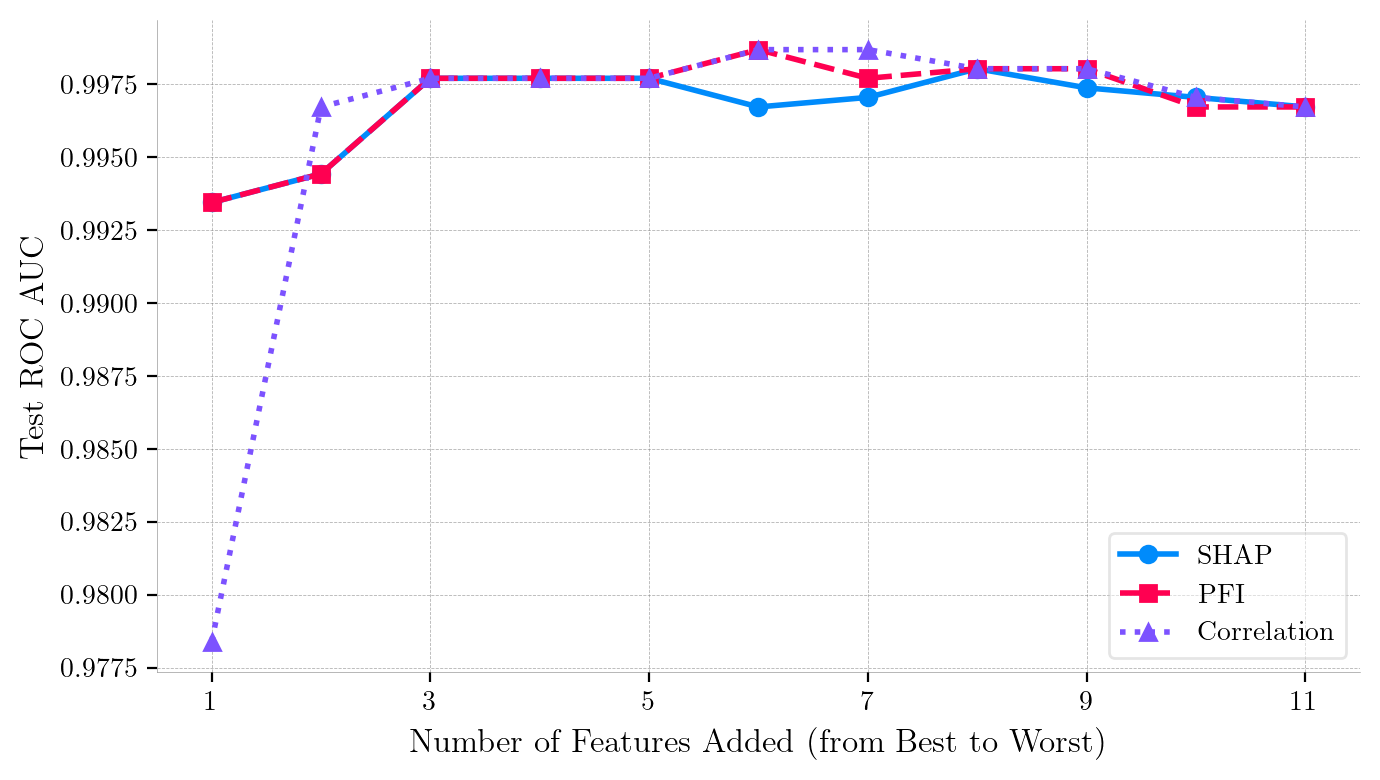

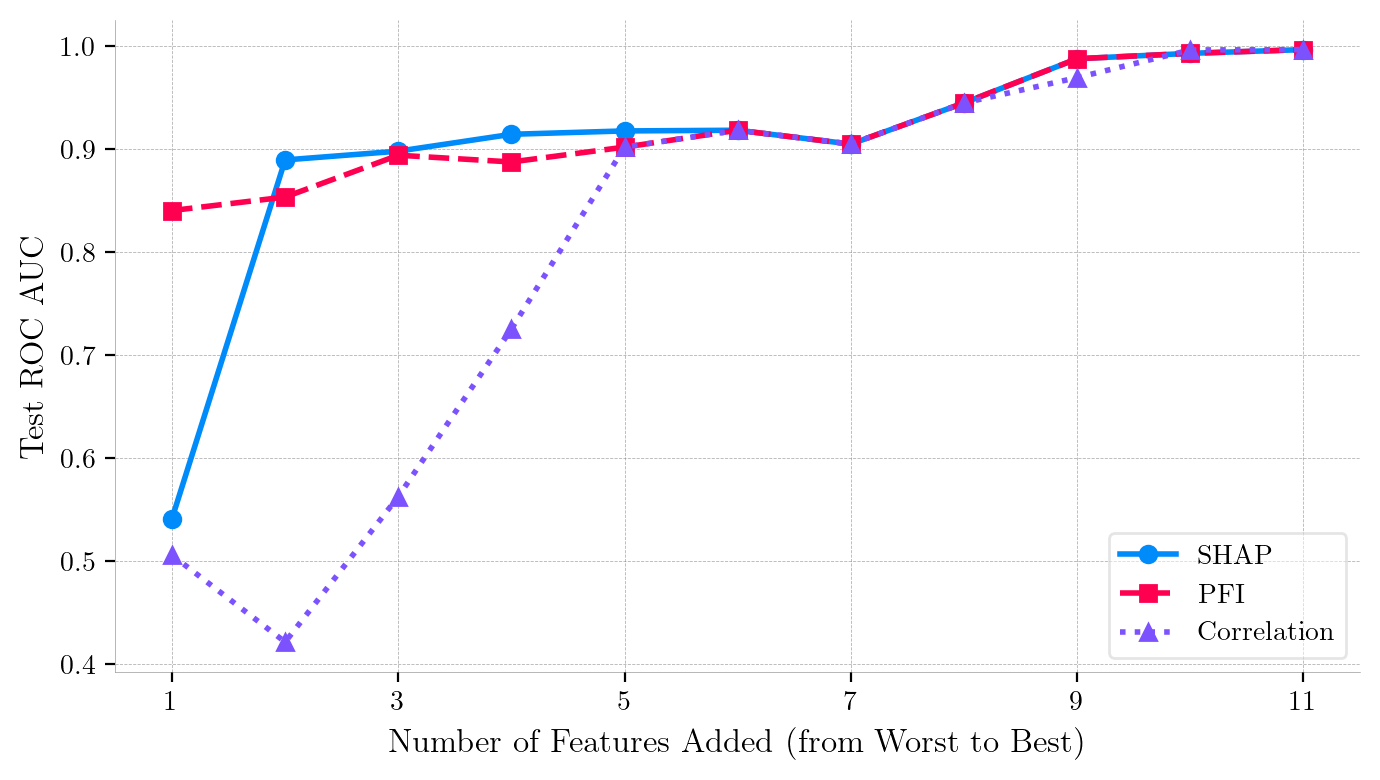

Done.


In [ ]:
# Iterative Feature Addition After Clustering

print("Loading and preprocessing Breast Cancer dataset...")

data = load_breast_cancer(as_frame=True)
X = data.data
X = X[['worst perimeter', 'radius error', 'worst concave points', 'worst texture', 
       'worst symmetry', 'symmetry error', 'texture error', 'worst smoothness', 
       'worst fractal dimension', 'concave points error', 'smoothness error']]
y = data.target
feature_names = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=feature_names,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=feature_names,
    index=X_test.index
)

print("Training baseline Logistic Regression model...")
baseline_model = LogisticRegression(max_iter=1000, random_state=42)
baseline_model.fit(X_train_scaled, y_train)

baseline_pred = baseline_model.predict_proba(X_test_scaled)[:, 1]
print(f"Baseline ROC AUC: {roc_auc_score(y_test, baseline_pred):.4f}")
print("=" * 60, "\n")

print("Calculating feature rankings...")

shap_ranking = ['worst perimeter', 'radius error', 'worst concave points', 'worst texture', 
       'worst symmetry', 'symmetry error', 'texture error', 'worst smoothness', 
       'worst fractal dimension', 'concave points error', 'smoothness error']

pfi = permutation_importance(
    baseline_model,
    X_test_scaled,
    y_test,
    n_repeats=30,
    random_state=42,
    scoring="roc_auc",
    n_jobs=-1
)
pfi_ranking = [
    f for _, f in sorted(zip(pfi.importances_mean, feature_names), reverse=True)
]

train_df = X_train_scaled.copy()
train_df["target"] = y_train.values
corr_values = (
    train_df.corr()["target"]
    .abs()
    .drop("target")
    .sort_values(ascending=False)
)
corr_ranking = corr_values.index.tolist()

rankings = {
    "SHAP": shap_ranking,
    "PFI": pfi_ranking,
    "Correlation": corr_ranking
}

print("Generating Iterative Feature Selection Scores...\n")

scenarios = ["add_best", "add_worst"]

for mode in scenarios:
    print("#" * 70)
    print(f"SCENARIO: {mode.upper().replace('_', ' ')}")
    print("#" * 70)

    for method, ranking in rankings.items():
        print(f"\n--- Method: {method} ---")
        df = get_trajectory_data(
            ranking, mode,
            X_train_scaled, y_train,
            X_test_scaled, y_test
        )
        print(df.to_string(index=False))
        print("-" * 50)

print("Tables generated.")
print("=" * 60)

colors = {"SHAP": "#008BFB", "PFI": "#FF0051", "Correlation": "#7C52FF"}
markers = {"SHAP": "o", "PFI": "s", "Correlation": "^"}
styles = {"SHAP": "-", "PFI": "--", "Correlation": ":"}

plot_scenarios = [
    ("add_best", "Number of Features Added (from Best to Worst)"),
    ("add_worst", "Number of Features Added (from Worst to Best)")
]

print("Generating plots...")

for mode, xlabel in plot_scenarios:
    plt.figure(figsize=(7, 4))

    for method, ranking in rankings.items():
        df = get_trajectory_data(
            ranking, mode,
            X_train_scaled, y_train,
            X_test_scaled, y_test
        )
        xs, ys = trajectory_to_xy(df)

        plt.plot(
            xs, ys,
            label=method,
            color=colors[method],
            marker=markers[method],
            linestyle=styles[method],
            linewidth=2,
            markersize=6
        )
        
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel("Test ROC AUC", fontsize=12)
    #plt.title(f"Scenario: {mode.replace('_', ' ').title()}", fontsize=14)
    plt.xticks(range(1, len(feature_names) + 1, 2))
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

print("Done.")

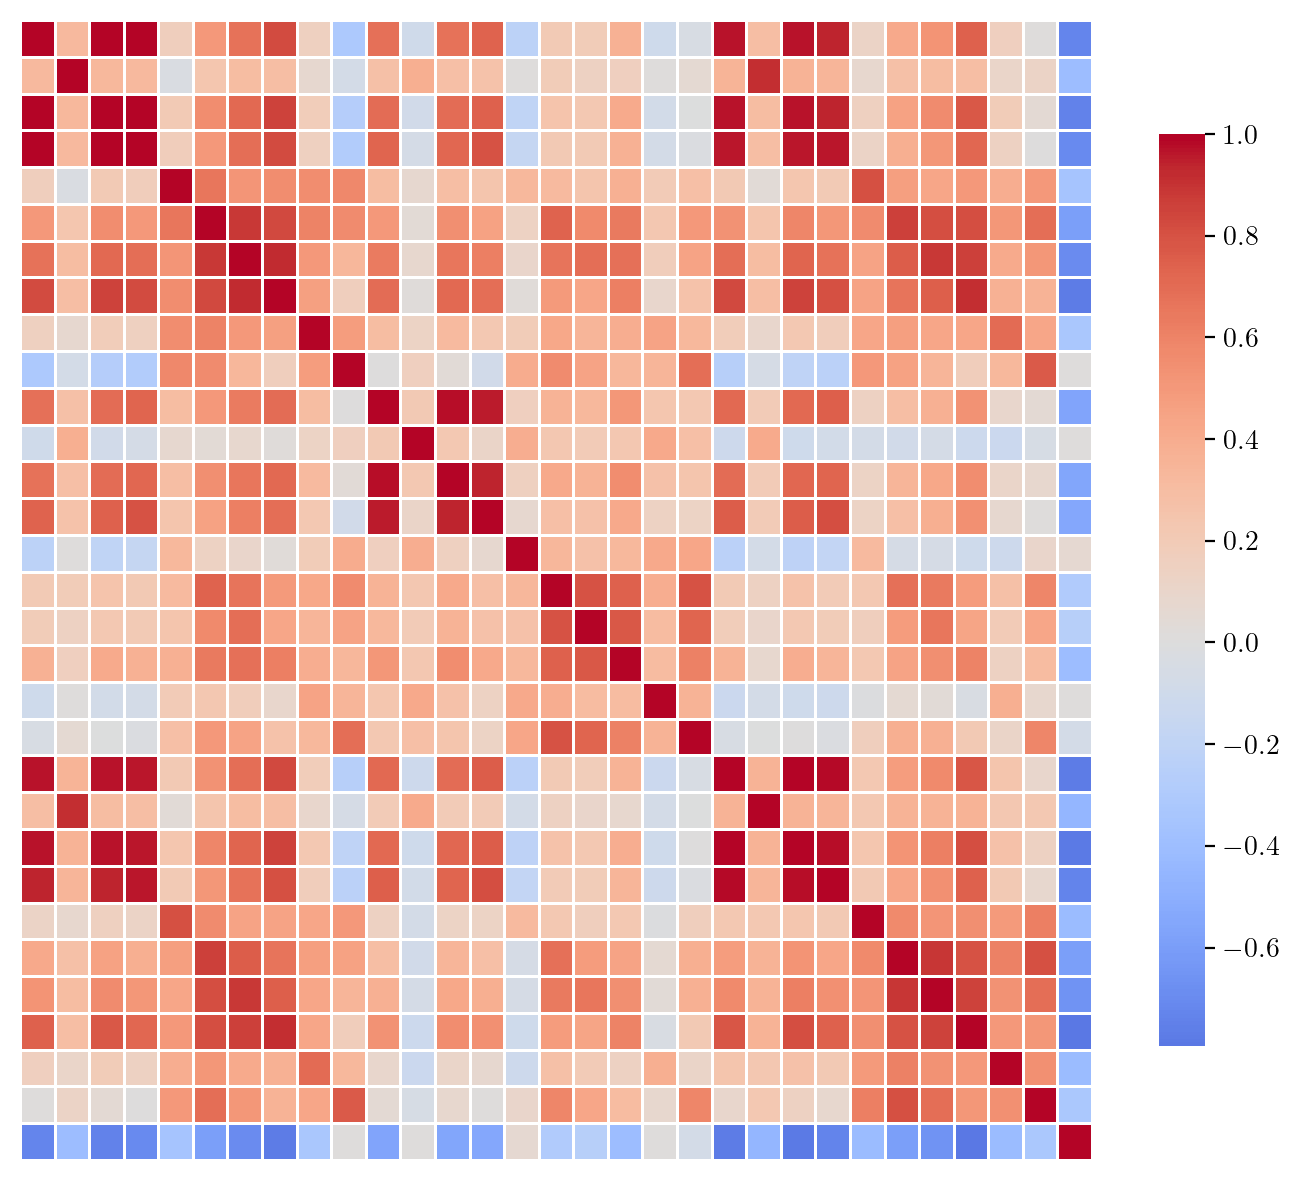

In [ ]:
# Correlation Matrix Heatmap

data = load_breast_cancer()
X = data.data
y = data.target

df = pd.DataFrame(X, columns=data.feature_names)
df["target"] = y  # already numeric (0 = malignant, 1 = benign)

corr_matrix = df.corr()

plt.figure(figsize=(7, 6))
sns.heatmap(
    corr_matrix,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])
#plt.title("Correlation Matrix: Breast Cancer Dataset", fontsize=16)
plt.tight_layout()
plt.show()


Computing NMI matrix...


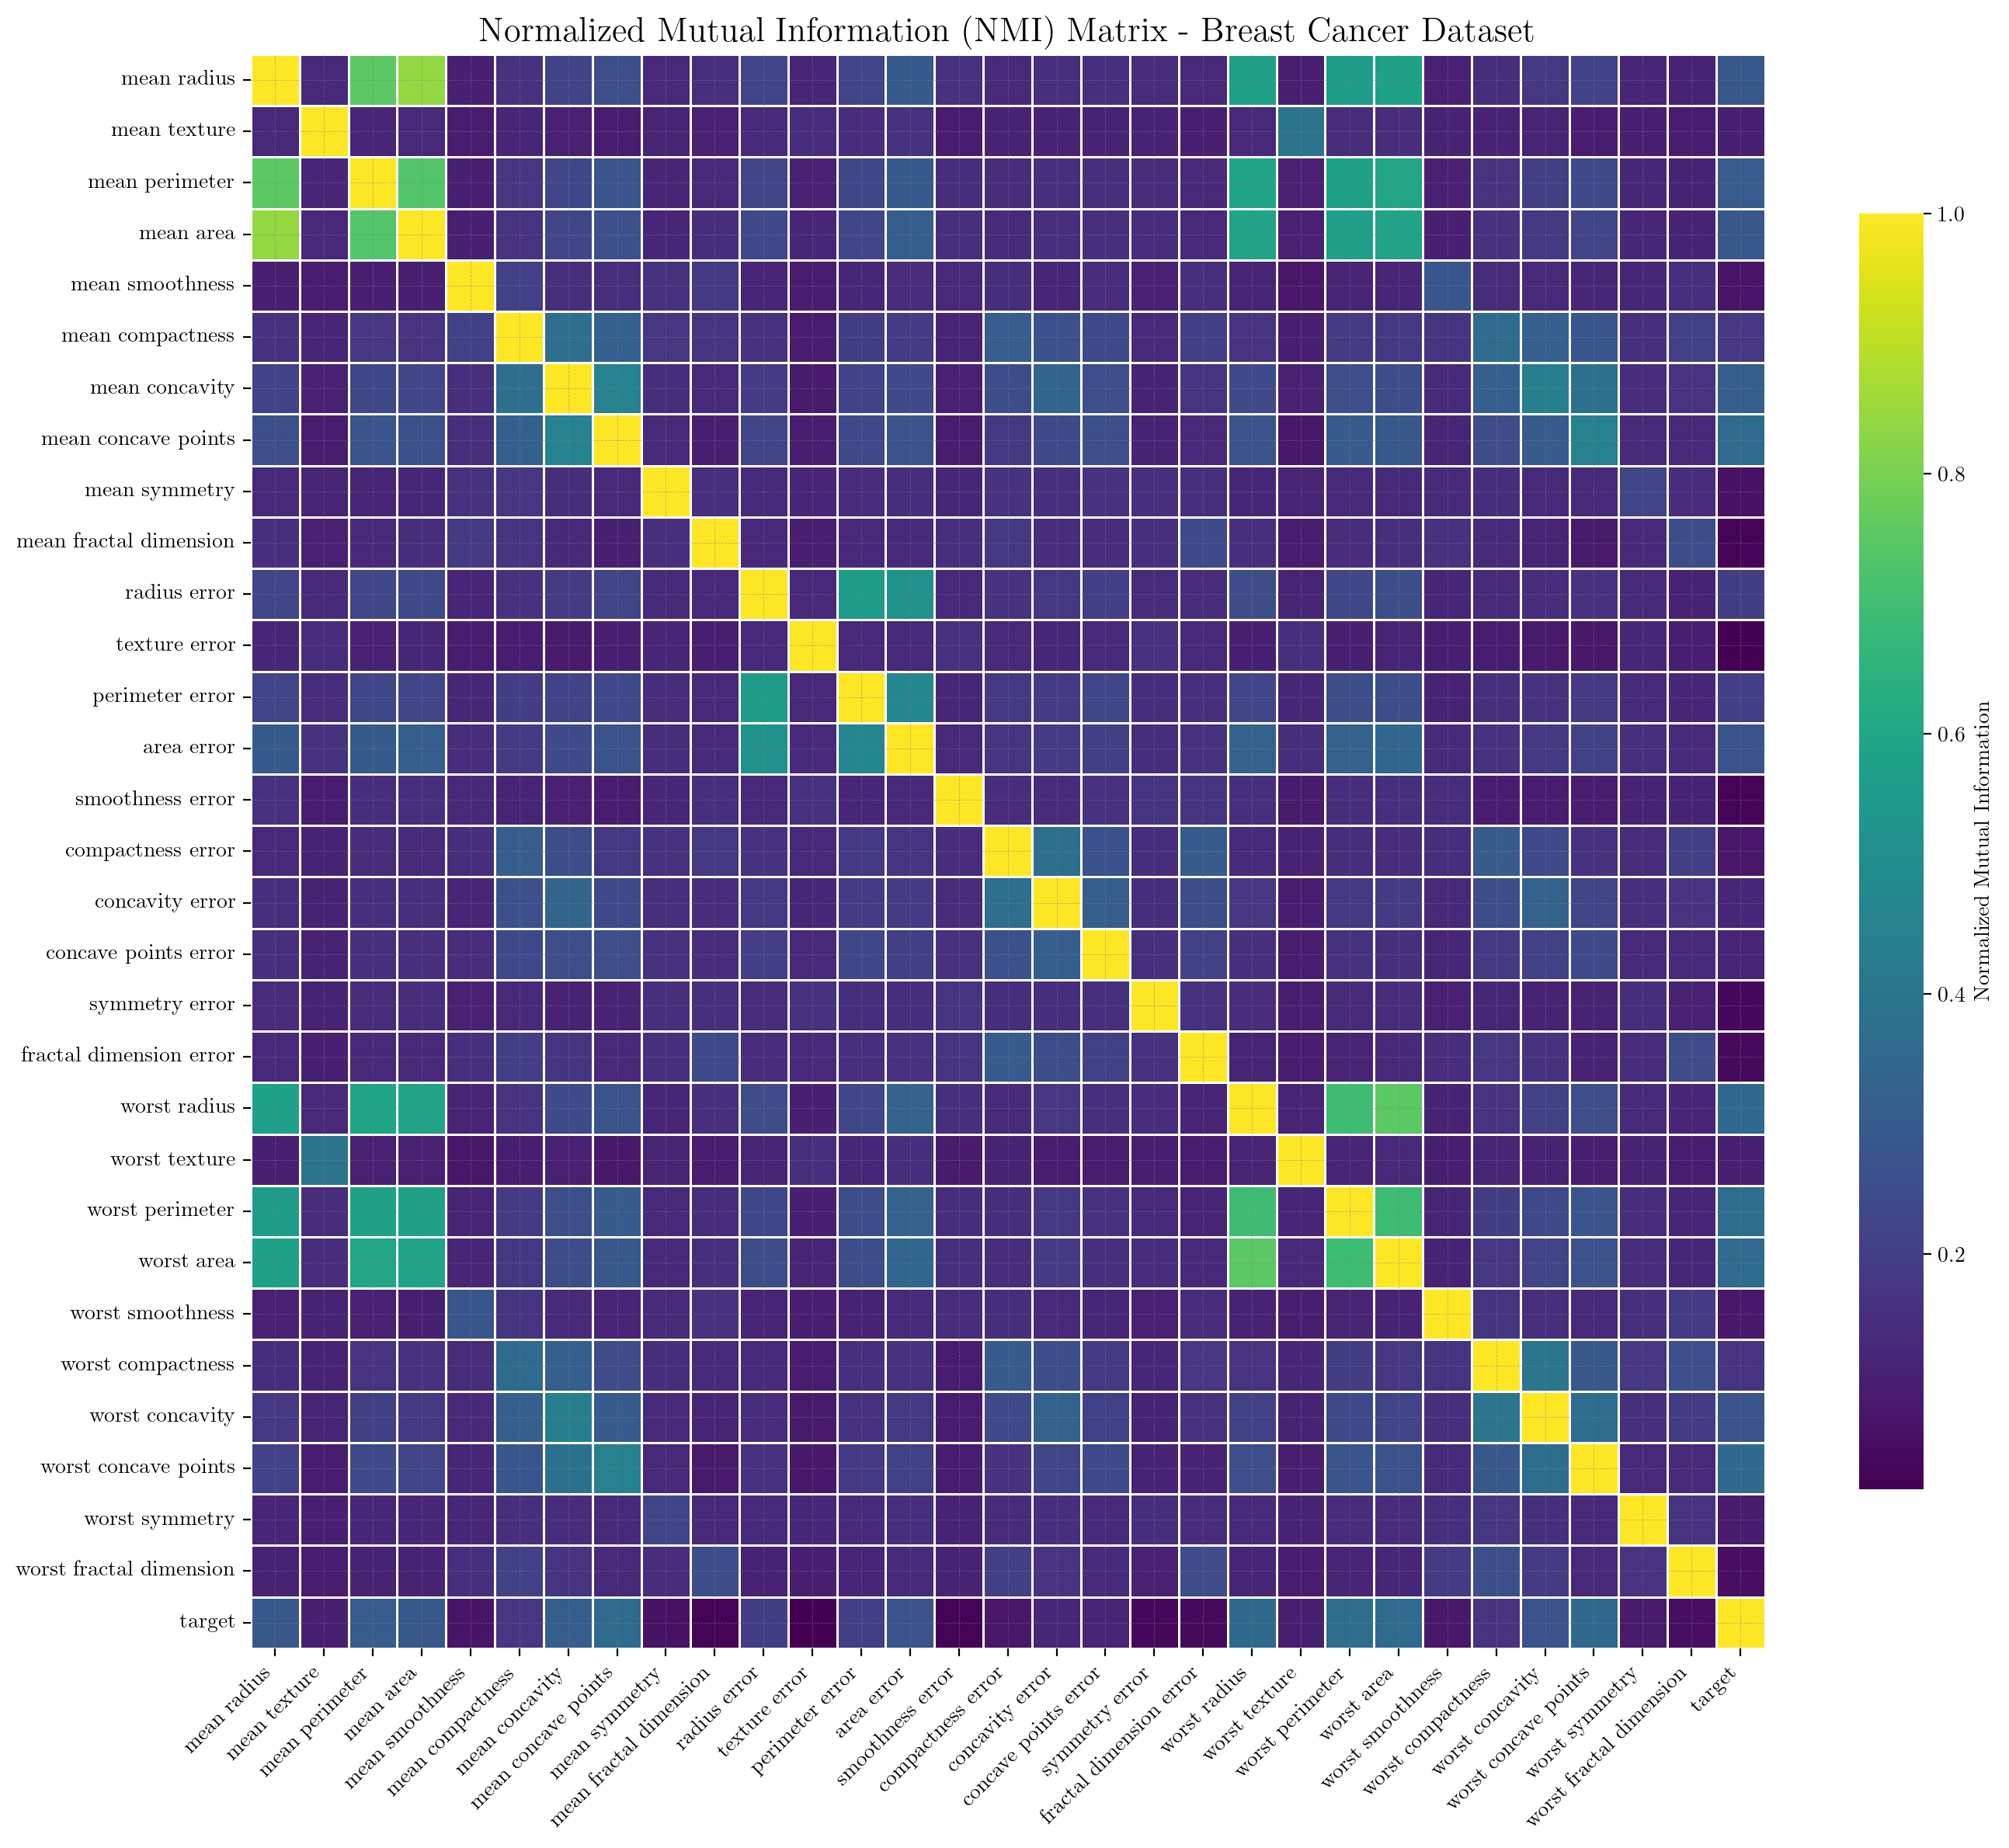

In [ ]:
# NMI Matrix Heatmap

data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df["target"] = data.target

df = df.fillna(df.mean(numeric_only=True))

print("Computing NMI matrix...")
columns = df.columns
n_cols = len(columns)
nmi_matrix = pd.DataFrame(np.zeros((n_cols, n_cols)), index=columns, columns=columns)

for i in range(n_cols):
    for j in range(i, n_cols):
        col1 = columns[i]
        col2 = columns[j]
        
        val = normalized_mutual_information(df[col1].values, df[col2].values)
        nmi_matrix.loc[col1, col2] = val
        nmi_matrix.loc[col2, col1] = val

plt.figure(figsize=(14, 12))
sns.heatmap(
    nmi_matrix,
    cmap='viridis',
    annot=False,
    linewidths=0.4,
    cbar_kws={"shrink": .8, "label": "Normalized Mutual Information"}
)
plt.title("Normalized Mutual Information (NMI) Matrix - Breast Cancer Dataset", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [87]:
for i in nmi_matrix["target"].sort_values(ascending=False).index:
    feature = i
    corr_value = nmi_matrix["target"].sort_values(ascending=False).loc[i]
    print(f"{feature}: {corr_value:.4f}")

target: 1.0000
worst perimeter: 0.3676
worst area: 0.3602
mean concave points: 0.3577
worst radius: 0.3514
worst concave points: 0.3498
mean concavity: 0.3068
mean perimeter: 0.3064
mean area: 0.2869
mean radius: 0.2842
area error: 0.2720
worst concavity: 0.2689
perimeter error: 0.1985
radius error: 0.1940
mean compactness: 0.1764
worst compactness: 0.1675
concavity error: 0.1238
concave points error: 0.1169
mean texture: 0.1073
worst texture: 0.1067
worst symmetry: 0.0904
worst smoothness: 0.0815
compactness error: 0.0790
mean smoothness: 0.0706
mean symmetry: 0.0643
worst fractal dimension: 0.0572
fractal dimension error: 0.0445
symmetry error: 0.0396
smoothness error: 0.0297
mean fractal dimension: 0.0288
texture error: 0.0195
